In [220]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [221]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [222]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [223]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 Pre-processing of the data

### 1.2.1 Pre-processing of the sub-cateogry values

In [224]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in tqdm(catogories):
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)








  0%|                                                                                       | 0/109248 [00:00<?, ?it/s]



 19%|█████████████▋                                                         | 21114/109248 [00:00<00:00, 209545.00it/s]



 40%|████████████████████████████▌                                          | 43894/109248 [00:00<00:00, 214282.22it/s]



 66%|███████████████████████████████████████████████                        | 72407/109248 [00:00<00:00, 231131.89it/s]



 91%|████████████████████████████████████████████████████████████████▌      | 99379/109248 [00:00<00:00, 241023.95it/s]



100%|██████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 245605.51it/s]

In [225]:
from collections import Counter
my_counter = Counter()
for word in tqdm(project_data['clean_categories'].values):
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))





  0%|                                                                                       | 0/109248 [00:00<?, ?it/s]



 22%|███████████████▍                                                       | 23707/109248 [00:00<00:00, 235357.08it/s]



 42%|█████████████████████████████▍                                         | 45360/109248 [00:00<00:00, 228842.21it/s]



 63%|████████████████████████████████████████████▌                          | 68521/109248 [00:00<00:00, 229167.30it/s]



 82%|██████████████████████████████████████████████████████████▏            | 89560/109248 [00:00<00:00, 222673.06it/s]



100%|█████████████████████████████████████████████████████████████████████▊| 108958/109248 [00:00<00:00, 212676.92it/s]



100%|██████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 215207.47it/s]

### 1.2.2 preprocessing of `project_subject_subcategories`

In [226]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### 1.2.3 Text preprocessing

In [227]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [228]:
# project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

In [229]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [230]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [231]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [232]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in project_data['essay'].values:
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

In [233]:
# after preprocesing
preprocessed_essays[20000]

'kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism eager beavers always strive work hardest working past limitations materials ones seek students teach title school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore ever felt like ants pants needed groove move meeting kids feel time want able move learn say wobble chairs answer love develop core enhances gross motor turn fine motor skills also want learn games kids not want sit worksheets want learn count jumping playing physical engagement key success number toss color shape mats make happen students forget work fun 6 year old deserves nannan'

In [234]:
project_data['essay'] = preprocessed_essays

<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

In [235]:
# similarly you can preprocess the titles also
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in project_data['project_title'].values:
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

In [236]:
preprocessed_titles[20000]

'need move input'

In [237]:
project_data['project_title'] = preprocessed_titles

### 1.4.1 Preprocessing of the teacher_prefix

In [238]:
project_data['teacher_prefix'].fillna("Others",inplace = True)
set(project_data['teacher_prefix'].values)

{'Dr.', 'Mr.', 'Mrs.', 'Ms.', 'Others', 'Teacher'}

### 1.4.2 Preprocessing of the price

In [239]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

###  1.4.3 Preprocessing of the Project_grad

In [240]:
lst = list(project_data['project_grade_category'].values)
preprocessed_grades = []
for l in lst:
    l = l.replace(' ','_')
    preprocessed_grades.append(l)
set(preprocessed_grades)

{'Grades_3-5', 'Grades_6-8', 'Grades_9-12', 'Grades_PreK-2'}

In [241]:
project_data['project_grade_category'] = preprocessed_grades

## 1.5 Preparing data for models

In [242]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'quantity'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [243]:
y = project_data["project_is_approved"]
X = project_data.drop("project_is_approved",axis = 1)
X.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'quantity'],
      dtype='object')

In [244]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [245]:
X_train.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
45950       43994  p025258  3fc08e89e5181c21d51c90e7c971a31c           Mrs.   
45735      118335  p132156  73c157488a91ce09c657cc4516702a1f           Mrs.   

      school_state project_submitted_datetime project_grade_category  \
45950           TX        2017-01-06 09:57:36             Grades_3-5   
45735           FL        2017-02-02 13:12:58             Grades_6-8   

                  project_title  \
45950               wiggle work   
45735  wanted headphones needed   

                                         project_essay_1  \
45950  My students are a part of a dual language prog...   
45735  Our Tech classrooms are innovating and excitin...   

                                project_resource_summary  \
45950  My students need Hokki stools to control their...   
45735  My students need headphones to complete our la...   

       teacher_number_of_previously_posted_projects clean_categories  \
45950                                             9    Health_Sports   
45735                                             1  AppliedLearning   

               clean_subcategories  \
45950  Gym_Fitness Health_Wellness   
45735                        Other   

                                                   essay   price  quantity  
45950  students part dual language program learn two ...  220.92         3  
45735  tech classrooms innovating exciting students s...    5.98        45

In [246]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(49041, 16) (49041,)
(24155, 16) (24155,)
(36052, 16) (36052,)


### 1.5.4 Numerical Variables

In [247]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'quantity'],
      dtype='object')

In [248]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


In [249]:
normalizer = Normalizer()
# normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_tnopp_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_cv_tnopp_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_tnopp_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_tnopp_norm.shape, y_train.shape)
print(X_cv_tnopp_norm.shape, y_cv.shape)
print(X_test_tnopp_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


### Vectorizing Text data

### BOW Vectorizations

In [250]:
vectorizer = CountVectorizer(min_df=10, max_features=5000 )
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)
essay_bow_features = vectorizer.get_feature_names()


After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


In [251]:
vectorizer = CountVectorizer(min_df=10, max_features=5000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.transform(X_train['project_title'].values)
X_cv_title_bow = vectorizer.transform(X_cv['project_title'].values)
X_test_title_bow = vectorizer.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)
print("="*100)
title_bow_features = vectorizer.get_feature_names()

After vectorizations
(49041, 2011) (49041,)
(24155, 2011) (24155,)
(36052, 2011) (36052,)


###  TF-IDF Vectorizations

In [252]:
vectorizer = TfidfVectorizer(min_df=10, max_features=5000 )
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_idf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_idf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_idf = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_idf.shape, y_train.shape)
print(X_cv_essay_idf.shape, y_cv.shape)
print(X_test_essay_idf.shape, y_test.shape)
print("="*100)
essay_tfidf_features = vectorizer.get_feature_names()

After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


In [253]:
vectorizer = CountVectorizer(min_df=10, max_features=5000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_idf = vectorizer.transform(X_train['project_title'].values)
X_cv_title_idf = vectorizer.transform(X_cv['project_title'].values)
X_test_title_idf = vectorizer.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_title_idf.shape, y_train.shape)
print(X_cv_title_idf.shape, y_cv.shape)
print(X_test_title_idf.shape, y_test.shape)
print("="*100)
title_tfidf_features = vectorizer.get_feature_names()

After vectorizations
(49041, 2011) (49041,)
(24155, 2011) (24155,)
(36052, 2011) (36052,)


### 1.5.2 AVG-W2V 

In [254]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [255]:
avg_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)







  0%|                                                                                        | 0/49041 [00:00<?, ?it/s]



  0%|▎                                                                           | 210/49041 [00:00<00:23, 2084.78it/s]



  1%|▋                                                                           | 424/49041 [00:00<00:23, 2096.52it/s]



  1%|█                                                                           | 649/49041 [00:00<00:22, 2135.88it/s]



  2%|█▍                                                                          | 924/49041 [00:00<00:21, 2285.07it/s]



  2%|█▊                                                                         | 1208/49041 [00:00<00:19, 2422.68it/s]



  3%|██▏                                                                        | 1468/49041 [00:00<00:19, 2468.30it/s]



  4%|██▋                                                                        | 1741/49041 [00:00<00:18, 2536.22it/s]



  4%|███    

 36%|██████████████████████████▎                                               | 17448/49041 [00:06<00:12, 2550.85it/s]



 36%|██████████████████████████▊                                               | 17748/49041 [00:06<00:11, 2665.60it/s]



 37%|███████████████████████████▏                                              | 18031/49041 [00:07<00:11, 2707.21it/s]



 37%|███████████████████████████▋                                              | 18349/49041 [00:07<00:10, 2828.07it/s]



 38%|████████████████████████████                                              | 18635/49041 [00:07<00:10, 2814.74it/s]



 39%|████████████████████████████▌                                             | 18919/49041 [00:07<00:11, 2665.86it/s]



 39%|████████████████████████████▉                                             | 19189/49041 [00:07<00:16, 1864.59it/s]



 40%|█████████████████████████████▎                                            | 19411/49041 [00:07<00:19, 1525.03it/s]



 40%|███████████

 63%|██████████████████████████████████████████████▉                           | 31065/49041 [00:14<00:09, 1825.63it/s]



 64%|███████████████████████████████████████████████▏                          | 31251/49041 [00:14<00:09, 1831.84it/s]



 64%|███████████████████████████████████████████████▍                          | 31436/49041 [00:14<00:09, 1833.26it/s]



 65%|███████████████████████████████████████████████▊                          | 31647/49041 [00:14<00:09, 1904.57it/s]



 65%|████████████████████████████████████████████████                          | 31876/49041 [00:14<00:08, 2002.01it/s]



 65%|████████████████████████████████████████████████▍                         | 32088/49041 [00:14<00:08, 2031.73it/s]



 66%|████████████████████████████████████████████████▋                         | 32305/49041 [00:14<00:08, 2067.00it/s]



 66%|█████████████████████████████████████████████████                         | 32520/49041 [00:15<00:07, 2086.77it/s]



 67%|███████████

 90%|██████████████████████████████████████████████████████████████████▋       | 44214/49041 [00:21<00:02, 1845.99it/s]



 91%|███████████████████████████████████████████████████████████████████       | 44403/49041 [00:21<00:03, 1453.70it/s]



 91%|███████████████████████████████████████████████████████████████████▏      | 44565/49041 [00:21<00:03, 1407.37it/s]



 91%|███████████████████████████████████████████████████████████████████▍      | 44718/49041 [00:21<00:03, 1388.28it/s]



 91%|███████████████████████████████████████████████████████████████████▋      | 44865/49041 [00:21<00:03, 1339.71it/s]



 92%|███████████████████████████████████████████████████████████████████▉      | 45017/49041 [00:22<00:02, 1386.37it/s]



 92%|████████████████████████████████████████████████████████████████████▏     | 45183/49041 [00:22<00:02, 1455.69it/s]



 92%|████████████████████████████████████████████████████████████████████▍     | 45333/49041 [00:22<00:02, 1427.99it/s]



 93%|███████████

In [256]:
avg_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)





  0%|                                                                                        | 0/24155 [00:00<?, ?it/s]



  1%|▍                                                                           | 153/24155 [00:00<00:15, 1518.88it/s]



  1%|▉                                                                           | 291/24155 [00:00<00:16, 1470.93it/s]



  2%|█▍                                                                          | 438/24155 [00:00<00:16, 1467.43it/s]



  3%|█▉                                                                          | 610/24155 [00:00<00:15, 1532.06it/s]



  3%|██▍                                                                         | 774/24155 [00:00<00:14, 1559.66it/s]



  4%|██▉                                                                         | 936/24155 [00:00<00:14, 1573.93it/s]



  4%|███▎                                                                       | 1079/24155 [00:00<00:15, 1524.23it/s]



  5%|███▉   

 51%|█████████████████████████████████████▉                                    | 12402/24155 [00:07<00:05, 2028.89it/s]



 53%|██████████████████████████████████████▉                                   | 12691/24155 [00:07<00:05, 2224.30it/s]



 54%|███████████████████████████████████████▋                                  | 12940/24155 [00:07<00:04, 2293.12it/s]



 55%|████████████████████████████████████████▎                                 | 13176/24155 [00:07<00:04, 2294.50it/s]



 56%|█████████████████████████████████████████                                 | 13410/24155 [00:07<00:05, 2145.09it/s]



 56%|█████████████████████████████████████████▊                                | 13630/24155 [00:07<00:04, 2125.45it/s]



 57%|██████████████████████████████████████████▍                               | 13855/24155 [00:07<00:04, 2156.81it/s]



 58%|███████████████████████████████████████████▏                              | 14101/24155 [00:07<00:04, 2235.16it/s]



 59%|███████████

In [257]:
avg_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)





  0%|                                                                                        | 0/36052 [00:00<?, ?it/s]



  1%|▌                                                                           | 247/36052 [00:00<00:14, 2451.42it/s]



  1%|▉                                                                           | 471/36052 [00:00<00:14, 2378.57it/s]



  2%|█▍                                                                          | 689/36052 [00:00<00:15, 2309.94it/s]



  3%|██                                                                          | 961/36052 [00:00<00:14, 2414.65it/s]



  3%|██▍                                                                        | 1196/36052 [00:00<00:14, 2389.54it/s]



  4%|██▉                                                                        | 1428/36052 [00:00<00:14, 2362.97it/s]



  5%|███▌                                                                       | 1687/36052 [00:00<00:14, 2421.80it/s]



  5%|███▉   

 49%|████████████████████████████████████                                      | 17593/36052 [00:06<00:07, 2465.68it/s]



 50%|████████████████████████████████████▋                                     | 17864/36052 [00:07<00:07, 2529.05it/s]



 50%|█████████████████████████████████████▏                                    | 18138/36052 [00:07<00:06, 2583.49it/s]



 51%|█████████████████████████████████████▊                                    | 18425/36052 [00:07<00:06, 2657.85it/s]



 52%|██████████████████████████████████████▎                                   | 18693/36052 [00:07<00:07, 2327.11it/s]



 53%|██████████████████████████████████████▉                                   | 18986/36052 [00:07<00:06, 2475.62it/s]



 53%|███████████████████████████████████████▌                                  | 19267/36052 [00:07<00:06, 2561.91it/s]



 54%|████████████████████████████████████████                                  | 19531/36052 [00:07<00:06, 2564.56it/s]



 55%|███████████

### For title

In [258]:
w2v_title_train = []; # the avg-w2v for each sentence/review is stored in this list  
for sentence in tqdm(X_train['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_title_train.append(vector)





  0%|                                                                                        | 0/49041 [00:00<?, ?it/s]



 12%|████████▊                                                                 | 5846/49041 [00:00<00:00, 58035.82it/s]



 20%|██████████████▋                                                           | 9693/49041 [00:00<00:00, 50208.78it/s]



 30%|█████████████████████▊                                                   | 14618/49041 [00:00<00:00, 49806.88it/s]



 40%|█████████████████████████████▍                                           | 19795/49041 [00:00<00:00, 50272.63it/s]



 49%|███████████████████████████████████▊                                     | 24096/49041 [00:00<00:00, 47732.51it/s]



 58%|██████████████████████████████████████████▏                              | 28350/49041 [00:00<00:00, 45937.08it/s]



 67%|█████████████████████████████████████████████████                        | 32927/49041 [00:00<00:00, 45786.44it/s]



 78%|███████

In [259]:
w2v_title_cv = []; # the avg-w2v for each sentence/review is stored in this list 
for sentence in tqdm(X_cv['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_title_cv.append(vector)





  0%|                                                                                        | 0/24155 [00:00<?, ?it/s]



 19%|█████████████▋                                                            | 4477/24155 [00:00<00:00, 44445.57it/s]



 39%|█████████████████████████████▏                                            | 9518/24155 [00:00<00:00, 45989.04it/s]



 55%|████████████████████████████████████████▍                                | 13392/24155 [00:00<00:00, 43437.70it/s]



 77%|████████████████████████████████████████████████████████                 | 18552/24155 [00:00<00:00, 45513.49it/s]



 98%|███████████████████████████████████████████████████████████████████████▍ | 23628/24155 [00:00<00:00, 46874.87it/s]



100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 45870.49it/s]

In [260]:
w2v_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_title_test.append(vector)





  0%|                                                                                        | 0/36052 [00:00<?, ?it/s]



 12%|████████▉                                                                 | 4327/36052 [00:00<00:00, 42956.65it/s]



 24%|█████████████████▊                                                        | 8708/36052 [00:00<00:00, 43115.93it/s]



 34%|█████████████████████████▏                                               | 12429/36052 [00:00<00:00, 41056.45it/s]



 47%|██████████████████████████████████                                       | 16808/36052 [00:00<00:00, 41752.78it/s]



 59%|███████████████████████████████████████████▏                             | 21337/36052 [00:00<00:00, 42666.11it/s]



 71%|███████████████████████████████████████████████████▉                     | 25670/36052 [00:00<00:00, 42770.54it/s]



 84%|█████████████████████████████████████████████████████████████▍           | 30332/36052 [00:00<00:00, 43766.54it/s]



 98%|███████

### 1.5.2 TF-IDF weighted W2V

In [261]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))





  0%|                                                                                        | 0/49041 [00:00<?, ?it/s]



  0%|                                                                              | 32/49041 [00:00<02:37, 311.51it/s]



  0%|                                                                              | 56/49041 [00:00<02:52, 284.20it/s]



  0%|▏                                                                             | 88/49041 [00:00<02:48, 291.08it/s]



  0%|▏                                                                            | 115/49041 [00:00<02:52, 282.87it/s]



  0%|▏                                                                            | 144/49041 [00:00<02:52, 283.53it/s]



  0%|▎                                                                            | 175/49041 [00:00<02:48, 289.58it/s]



  0%|▎                                                                            | 209/49041 [00:00<02:41, 302.47it/s]



  0%|▍      

  5%|███▌                                                                        | 2303/49041 [00:06<02:11, 354.68it/s]



  5%|███▋                                                                        | 2340/49041 [00:07<02:10, 358.38it/s]



  5%|███▋                                                                        | 2380/49041 [00:07<02:06, 368.16it/s]



  5%|███▋                                                                        | 2419/49041 [00:07<02:05, 372.60it/s]



  5%|███▊                                                                        | 2457/49041 [00:07<02:06, 367.46it/s]



  5%|███▊                                                                        | 2500/49041 [00:07<02:01, 382.44it/s]



  5%|███▉                                                                        | 2539/49041 [00:07<02:07, 364.56it/s]



  5%|███▉                                                                        | 2576/49041 [00:07<02:07, 364.27it/s]



  5%|████       

  9%|███████▏                                                                    | 4600/49041 [00:14<02:10, 340.73it/s]



  9%|███████▏                                                                    | 4638/49041 [00:14<02:07, 349.00it/s]



 10%|███████▏                                                                    | 4673/49041 [00:14<02:09, 343.42it/s]



 10%|███████▎                                                                    | 4717/49041 [00:14<02:00, 366.95it/s]



 10%|███████▎                                                                    | 4755/49041 [00:14<02:06, 350.58it/s]



 10%|███████▍                                                                    | 4794/49041 [00:14<02:03, 358.82it/s]



 10%|███████▍                                                                    | 4831/49041 [00:14<02:05, 353.03it/s]



 10%|███████▌                                                                    | 4868/49041 [00:14<02:05, 353.13it/s]



 10%|███████▌   

 14%|██████████▊                                                                 | 6974/49041 [00:21<01:55, 362.69it/s]



 14%|██████████▊                                                                 | 7011/49041 [00:21<01:59, 352.61it/s]



 14%|██████████▉                                                                 | 7047/49041 [00:21<02:03, 339.10it/s]



 14%|██████████▉                                                                 | 7082/49041 [00:21<02:12, 316.61it/s]



 15%|███████████                                                                 | 7115/49041 [00:21<02:15, 309.92it/s]



 15%|███████████                                                                 | 7157/49041 [00:21<02:04, 335.77it/s]



 15%|███████████▏                                                                | 7192/49041 [00:21<02:05, 332.44it/s]



 15%|███████████▏                                                                | 7228/49041 [00:22<02:04, 334.83it/s]



 15%|███████████

 19%|██████████████▌                                                             | 9371/49041 [00:28<01:57, 337.62it/s]



 19%|██████████████▌                                                             | 9408/49041 [00:28<01:55, 344.05it/s]



 19%|██████████████▋                                                             | 9450/49041 [00:28<01:49, 363.13it/s]



 19%|██████████████▋                                                             | 9487/49041 [00:28<01:56, 339.38it/s]



 19%|██████████████▊                                                             | 9522/49041 [00:28<02:13, 296.69it/s]



 19%|██████████████▊                                                             | 9554/49041 [00:28<02:15, 291.15it/s]



 20%|██████████████▊                                                             | 9593/49041 [00:29<02:05, 313.80it/s]



 20%|██████████████▉                                                             | 9626/49041 [00:29<02:03, 318.34it/s]



 20%|███████████

 24%|██████████████████                                                         | 11784/49041 [00:35<01:49, 340.00it/s]



 24%|██████████████████                                                         | 11819/49041 [00:35<01:50, 338.22it/s]



 24%|██████████████████▏                                                        | 11858/49041 [00:35<01:45, 351.58it/s]



 24%|██████████████████▏                                                        | 11894/49041 [00:35<01:47, 344.20it/s]



 24%|██████████████████▏                                                        | 11929/49041 [00:36<01:58, 312.86it/s]



 24%|██████████████████▎                                                        | 11971/49041 [00:36<01:49, 337.38it/s]



 24%|██████████████████▎                                                        | 12007/49041 [00:36<01:48, 342.17it/s]



 25%|██████████████████▍                                                        | 12047/49041 [00:36<01:43, 356.95it/s]



 25%|███████████

 29%|█████████████████████▊                                                     | 14282/49041 [00:42<01:53, 307.53it/s]



 29%|█████████████████████▉                                                     | 14317/49041 [00:42<01:49, 316.79it/s]



 29%|█████████████████████▉                                                     | 14353/49041 [00:42<01:46, 327.07it/s]



 29%|██████████████████████                                                     | 14388/49041 [00:42<01:45, 329.19it/s]



 29%|██████████████████████                                                     | 14422/49041 [00:43<01:47, 323.16it/s]



 29%|██████████████████████                                                     | 14455/49041 [00:43<02:08, 269.07it/s]



 30%|██████████████████████▏                                                    | 14485/49041 [00:43<02:05, 276.33it/s]



 30%|██████████████████████▏                                                    | 14520/49041 [00:43<01:57, 294.41it/s]



 30%|███████████

 34%|█████████████████████████▍                                                 | 16641/49041 [00:49<01:33, 347.26it/s]



 34%|█████████████████████████▌                                                 | 16679/49041 [00:49<01:31, 352.81it/s]



 34%|█████████████████████████▌                                                 | 16717/49041 [00:49<01:29, 359.80it/s]



 34%|█████████████████████████▋                                                 | 16760/49041 [00:50<01:25, 376.58it/s]



 34%|█████████████████████████▋                                                 | 16799/49041 [00:50<01:33, 343.69it/s]



 34%|█████████████████████████▋                                                 | 16835/49041 [00:50<01:36, 332.32it/s]



 34%|█████████████████████████▊                                                 | 16870/49041 [00:50<01:35, 336.72it/s]



 34%|█████████████████████████▊                                                 | 16905/49041 [00:50<01:35, 335.94it/s]



 35%|███████████

 39%|█████████████████████████████▏                                             | 19115/49041 [00:56<01:33, 318.53it/s]



 39%|█████████████████████████████▎                                             | 19153/49041 [00:56<01:31, 328.06it/s]



 39%|█████████████████████████████▎                                             | 19187/49041 [00:57<01:31, 325.20it/s]



 39%|█████████████████████████████▍                                             | 19220/49041 [00:57<01:32, 324.00it/s]



 39%|█████████████████████████████▍                                             | 19260/49041 [00:57<01:27, 340.32it/s]



 39%|█████████████████████████████▌                                             | 19295/49041 [00:57<01:27, 339.45it/s]



 39%|█████████████████████████████▌                                             | 19334/49041 [00:57<01:24, 351.53it/s]



 39%|█████████████████████████████▌                                             | 19370/49041 [00:57<01:24, 349.13it/s]



 40%|███████████

 44%|█████████████████████████████████                                          | 21582/49041 [01:03<01:19, 345.59it/s]



 44%|█████████████████████████████████                                          | 21618/49041 [01:04<01:21, 336.36it/s]



 44%|█████████████████████████████████                                          | 21652/49041 [01:04<01:22, 333.71it/s]



 44%|█████████████████████████████████▏                                         | 21686/49041 [01:04<01:26, 316.21it/s]



 44%|█████████████████████████████████▏                                         | 21718/49041 [01:04<01:26, 315.75it/s]



 44%|█████████████████████████████████▎                                         | 21754/49041 [01:04<01:23, 327.19it/s]



 44%|█████████████████████████████████▎                                         | 21790/49041 [01:04<01:21, 335.66it/s]



 45%|█████████████████████████████████▍                                         | 21825/49041 [01:04<01:20, 339.12it/s]



 45%|███████████

 49%|████████████████████████████████████▍                                      | 23836/49041 [01:11<01:35, 264.15it/s]



 49%|████████████████████████████████████▍                                      | 23863/49041 [01:11<01:41, 248.50it/s]



 49%|████████████████████████████████████▌                                      | 23889/49041 [01:11<01:41, 248.44it/s]



 49%|████████████████████████████████████▌                                      | 23919/49041 [01:11<01:36, 260.76it/s]



 49%|████████████████████████████████████▌                                      | 23946/49041 [01:11<01:42, 245.06it/s]



 49%|████████████████████████████████████▋                                      | 23975/49041 [01:11<01:37, 256.51it/s]



 49%|████████████████████████████████████▋                                      | 24006/49041 [01:11<01:33, 267.21it/s]



 49%|████████████████████████████████████▊                                      | 24042/49041 [01:11<01:26, 289.09it/s]



 49%|███████████

 53%|███████████████████████████████████████▍                                   | 25763/49041 [01:18<01:31, 255.42it/s]



 53%|███████████████████████████████████████▍                                   | 25790/49041 [01:18<01:32, 251.85it/s]



 53%|███████████████████████████████████████▍                                   | 25816/49041 [01:18<01:43, 225.40it/s]



 53%|███████████████████████████████████████▌                                   | 25840/49041 [01:18<01:58, 195.11it/s]



 53%|███████████████████████████████████████▌                                   | 25861/49041 [01:18<02:00, 192.93it/s]



 53%|███████████████████████████████████████▌                                   | 25889/49041 [01:18<01:49, 211.46it/s]



 53%|███████████████████████████████████████▋                                   | 25918/49041 [01:18<01:42, 225.49it/s]



 53%|███████████████████████████████████████▋                                   | 25944/49041 [01:19<01:38, 234.37it/s]



 53%|███████████

 56%|██████████████████████████████████████████                                 | 27530/49041 [01:25<01:42, 210.17it/s]



 56%|██████████████████████████████████████████▏                                | 27552/49041 [01:25<01:43, 207.77it/s]



 56%|██████████████████████████████████████████▏                                | 27574/49041 [01:26<01:46, 201.60it/s]



 56%|██████████████████████████████████████████▏                                | 27595/49041 [01:26<01:45, 202.44it/s]



 56%|██████████████████████████████████████████▏                                | 27616/49041 [01:26<01:47, 198.44it/s]



 56%|██████████████████████████████████████████▎                                | 27637/49041 [01:26<01:48, 197.94it/s]



 56%|██████████████████████████████████████████▎                                | 27661/49041 [01:26<01:42, 208.53it/s]



 56%|██████████████████████████████████████████▎                                | 27690/49041 [01:26<01:34, 226.80it/s]



 57%|███████████

 60%|█████████████████████████████████████████████▏                             | 29521/49041 [01:32<00:54, 360.34it/s]



 60%|█████████████████████████████████████████████▏                             | 29558/49041 [01:33<00:55, 351.09it/s]



 60%|█████████████████████████████████████████████▎                             | 29594/49041 [01:33<00:57, 337.13it/s]



 60%|█████████████████████████████████████████████▎                             | 29629/49041 [01:33<00:57, 340.19it/s]



 60%|█████████████████████████████████████████████▎                             | 29664/49041 [01:33<00:56, 341.34it/s]



 61%|█████████████████████████████████████████████▍                             | 29699/49041 [01:33<00:58, 331.49it/s]



 61%|█████████████████████████████████████████████▍                             | 29733/49041 [01:33<00:58, 329.13it/s]



 61%|█████████████████████████████████████████████▌                             | 29768/49041 [01:33<00:57, 334.42it/s]



 61%|███████████

 65%|████████████████████████████████████████████████▊                          | 31907/49041 [01:40<00:58, 291.49it/s]



 65%|████████████████████████████████████████████████▊                          | 31937/49041 [01:40<01:04, 265.40it/s]



 65%|████████████████████████████████████████████████▉                          | 31965/49041 [01:40<01:06, 255.12it/s]



 65%|████████████████████████████████████████████████▉                          | 31992/49041 [01:40<01:10, 240.90it/s]



 65%|████████████████████████████████████████████████▉                          | 32017/49041 [01:40<01:10, 240.25it/s]



 65%|█████████████████████████████████████████████████                          | 32049/49041 [01:40<01:05, 258.57it/s]



 65%|█████████████████████████████████████████████████                          | 32090/49041 [01:40<00:58, 287.90it/s]



 65%|█████████████████████████████████████████████████                          | 32121/49041 [01:40<00:58, 290.26it/s]



 66%|███████████

 70%|████████████████████████████████████████████████████▍                      | 34321/49041 [01:47<00:42, 343.36it/s]



 70%|████████████████████████████████████████████████████▌                      | 34358/49041 [01:47<00:42, 347.26it/s]



 70%|████████████████████████████████████████████████████▌                      | 34393/49041 [01:47<00:42, 346.29it/s]



 70%|████████████████████████████████████████████████████▋                      | 34428/49041 [01:47<00:43, 336.66it/s]



 70%|████████████████████████████████████████████████████▋                      | 34466/49041 [01:47<00:41, 347.93it/s]



 70%|████████████████████████████████████████████████████▊                      | 34502/49041 [01:47<00:41, 348.64it/s]



 70%|████████████████████████████████████████████████████▊                      | 34538/49041 [01:47<00:41, 350.24it/s]



 71%|████████████████████████████████████████████████████▉                      | 34574/49041 [01:48<00:55, 259.60it/s]



 71%|███████████

 74%|███████████████████████████████████████████████████████▊                   | 36506/49041 [01:54<01:09, 180.19it/s]



 74%|███████████████████████████████████████████████████████▊                   | 36526/49041 [01:54<01:09, 179.36it/s]



 75%|███████████████████████████████████████████████████████▉                   | 36545/49041 [01:54<01:14, 168.52it/s]



 75%|███████████████████████████████████████████████████████▉                   | 36563/49041 [01:55<01:16, 162.20it/s]



 75%|███████████████████████████████████████████████████████▉                   | 36585/49041 [01:55<01:11, 174.11it/s]



 75%|███████████████████████████████████████████████████████▉                   | 36612/49041 [01:55<01:03, 194.56it/s]



 75%|████████████████████████████████████████████████████████                   | 36643/49041 [01:55<00:56, 218.23it/s]



 75%|████████████████████████████████████████████████████████                   | 36679/49041 [01:55<00:50, 247.10it/s]



 75%|███████████

 79%|███████████████████████████████████████████████████████████▎               | 38753/49041 [02:02<00:30, 342.66it/s]



 79%|███████████████████████████████████████████████████████████▎               | 38788/49041 [02:02<00:31, 326.79it/s]



 79%|███████████████████████████████████████████████████████████▎               | 38822/49041 [02:02<00:30, 329.94it/s]



 79%|███████████████████████████████████████████████████████████▍               | 38862/49041 [02:02<00:29, 347.57it/s]



 79%|███████████████████████████████████████████████████████████▍               | 38898/49041 [02:02<00:29, 344.41it/s]



 79%|███████████████████████████████████████████████████████████▌               | 38933/49041 [02:02<00:30, 330.71it/s]



 79%|███████████████████████████████████████████████████████████▌               | 38968/49041 [02:02<00:30, 334.60it/s]



 80%|███████████████████████████████████████████████████████████▋               | 39002/49041 [02:02<00:32, 304.88it/s]



 80%|███████████

 84%|██████████████████████████████████████████████████████████████▊            | 41049/49041 [02:09<00:35, 222.46it/s]



 84%|██████████████████████████████████████████████████████████████▊            | 41073/49041 [02:09<00:35, 223.80it/s]



 84%|██████████████████████████████████████████████████████████████▊            | 41101/49041 [02:09<00:33, 237.70it/s]



 84%|██████████████████████████████████████████████████████████████▉            | 41130/49041 [02:09<00:31, 250.18it/s]



 84%|██████████████████████████████████████████████████████████████▉            | 41156/49041 [02:09<00:32, 244.68it/s]



 84%|██████████████████████████████████████████████████████████████▉            | 41186/49041 [02:09<00:30, 257.86it/s]



 84%|███████████████████████████████████████████████████████████████            | 41225/49041 [02:09<00:27, 285.92it/s]



 84%|███████████████████████████████████████████████████████████████            | 41261/49041 [02:09<00:25, 304.40it/s]



 84%|███████████

 89%|██████████████████████████████████████████████████████████████████▍        | 43435/49041 [02:16<00:17, 329.66it/s]



 89%|██████████████████████████████████████████████████████████████████▍        | 43469/49041 [02:16<00:17, 320.74it/s]



 89%|██████████████████████████████████████████████████████████████████▌        | 43502/49041 [02:16<00:18, 304.06it/s]



 89%|██████████████████████████████████████████████████████████████████▌        | 43536/49041 [02:16<00:17, 313.41it/s]



 89%|██████████████████████████████████████████████████████████████████▋        | 43582/49041 [02:16<00:15, 345.97it/s]



 89%|██████████████████████████████████████████████████████████████████▋        | 43624/49041 [02:16<00:14, 364.55it/s]



 89%|██████████████████████████████████████████████████████████████████▊        | 43662/49041 [02:16<00:14, 358.91it/s]



 89%|██████████████████████████████████████████████████████████████████▊        | 43704/49041 [02:17<00:14, 373.59it/s]



 89%|███████████

 94%|██████████████████████████████████████████████████████████████████████▏    | 45920/49041 [02:23<00:09, 330.54it/s]



 94%|██████████████████████████████████████████████████████████████████████▎    | 45962/49041 [02:23<00:08, 350.69it/s]



 94%|██████████████████████████████████████████████████████████████████████▎    | 45998/49041 [02:23<00:08, 338.77it/s]



 94%|██████████████████████████████████████████████████████████████████████▍    | 46033/49041 [02:23<00:08, 338.37it/s]



 94%|██████████████████████████████████████████████████████████████████████▍    | 46068/49041 [02:23<00:08, 332.33it/s]



 94%|██████████████████████████████████████████████████████████████████████▌    | 46108/49041 [02:23<00:08, 349.43it/s]



 94%|██████████████████████████████████████████████████████████████████████▌    | 46144/49041 [02:24<00:08, 337.95it/s]



 94%|██████████████████████████████████████████████████████████████████████▋    | 46188/49041 [02:24<00:07, 360.78it/s]



 94%|███████████

 99%|██████████████████████████████████████████████████████████████████████████ | 48443/49041 [02:30<00:01, 360.73it/s]



 99%|██████████████████████████████████████████████████████████████████████████▏| 48486/49041 [02:30<00:01, 378.32it/s]



 99%|██████████████████████████████████████████████████████████████████████████▏| 48525/49041 [02:30<00:01, 374.41it/s]



 99%|██████████████████████████████████████████████████████████████████████████▎| 48563/49041 [02:30<00:01, 374.15it/s]



 99%|██████████████████████████████████████████████████████████████████████████▎| 48604/49041 [02:30<00:01, 378.99it/s]



 99%|██████████████████████████████████████████████████████████████████████████▍| 48644/49041 [02:30<00:01, 383.09it/s]



 99%|██████████████████████████████████████████████████████████████████████████▍| 48683/49041 [02:31<00:00, 378.72it/s]



 99%|██████████████████████████████████████████████████████████████████████████▌| 48721/49041 [02:31<00:00, 374.89it/s]



 99%|███████████

49041
300


In [262]:
tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))





  0%|                                                                                        | 0/24155 [00:00<?, ?it/s]



  0%|                                                                              | 37/24155 [00:00<01:05, 367.31it/s]



  0%|▏                                                                             | 65/24155 [00:00<01:12, 332.63it/s]



  0%|▎                                                                            | 100/24155 [00:00<01:11, 335.98it/s]



  1%|▍                                                                            | 132/24155 [00:00<01:12, 330.27it/s]



  1%|▌                                                                            | 162/24155 [00:00<01:15, 317.79it/s]



  1%|▋                                                                            | 199/24155 [00:00<01:12, 331.19it/s]



  1%|▋                                                                            | 229/24155 [00:00<01:19, 299.37it/s]



  1%|▊      

 10%|███████▎                                                                    | 2306/24155 [00:07<01:02, 347.34it/s]



 10%|███████▎                                                                    | 2341/24155 [00:07<01:03, 341.30it/s]



 10%|███████▍                                                                    | 2376/24155 [00:07<01:03, 342.09it/s]



 10%|███████▌                                                                    | 2417/24155 [00:07<01:00, 359.28it/s]



 10%|███████▋                                                                    | 2454/24155 [00:07<01:03, 342.65it/s]



 10%|███████▊                                                                    | 2492/24155 [00:07<01:01, 350.36it/s]



 10%|███████▉                                                                    | 2531/24155 [00:07<00:59, 360.65it/s]



 11%|████████                                                                    | 2568/24155 [00:07<01:03, 339.71it/s]



 11%|████████▏  

 20%|██████████████▊                                                             | 4720/24155 [00:14<00:58, 332.98it/s]



 20%|██████████████▉                                                             | 4756/24155 [00:14<00:57, 338.99it/s]



 20%|███████████████                                                             | 4793/24155 [00:14<00:55, 346.00it/s]



 20%|███████████████▏                                                            | 4834/24155 [00:14<00:53, 361.39it/s]



 20%|███████████████▎                                                            | 4877/24155 [00:14<00:50, 379.25it/s]



 20%|███████████████▍                                                            | 4917/24155 [00:14<00:50, 381.14it/s]



 21%|███████████████▌                                                            | 4956/24155 [00:14<00:53, 360.10it/s]



 21%|███████████████▋                                                            | 4995/24155 [00:14<00:52, 366.79it/s]



 21%|███████████

 30%|██████████████████████▌                                                     | 7161/24155 [00:21<00:47, 358.96it/s]



 30%|██████████████████████▋                                                     | 7198/24155 [00:21<00:49, 344.29it/s]



 30%|██████████████████████▊                                                     | 7233/24155 [00:21<00:49, 340.21it/s]



 30%|██████████████████████▉                                                     | 7277/24155 [00:21<00:46, 360.85it/s]



 30%|███████████████████████                                                     | 7314/24155 [00:21<00:46, 362.73it/s]



 30%|███████████████████████▏                                                    | 7351/24155 [00:21<00:47, 356.67it/s]



 31%|███████████████████████▏                                                    | 7387/24155 [00:21<00:47, 353.74it/s]



 31%|███████████████████████▎                                                    | 7423/24155 [00:21<00:47, 349.33it/s]



 31%|███████████

 40%|██████████████████████████████▎                                             | 9616/24155 [00:28<00:45, 316.17it/s]



 40%|██████████████████████████████▎                                             | 9648/24155 [00:28<00:46, 311.10it/s]



 40%|██████████████████████████████▍                                             | 9680/24155 [00:28<00:47, 302.42it/s]



 40%|██████████████████████████████▌                                             | 9721/24155 [00:28<00:44, 326.88it/s]



 40%|██████████████████████████████▋                                             | 9755/24155 [00:28<00:45, 313.64it/s]



 41%|██████████████████████████████▊                                             | 9787/24155 [00:28<00:48, 298.16it/s]



 41%|██████████████████████████████▉                                             | 9824/24155 [00:28<00:45, 316.01it/s]



 41%|███████████████████████████████                                             | 9862/24155 [00:29<00:43, 331.32it/s]



 41%|███████████

 49%|████████████████████████████████████▉                                      | 11916/24155 [00:35<00:44, 277.75it/s]



 49%|█████████████████████████████████████                                      | 11945/24155 [00:35<00:47, 258.28it/s]



 50%|█████████████████████████████████████▏                                     | 11972/24155 [00:35<00:52, 233.44it/s]



 50%|█████████████████████████████████████▎                                     | 11997/24155 [00:35<00:52, 231.10it/s]



 50%|█████████████████████████████████████▎                                     | 12021/24155 [00:35<00:53, 228.55it/s]



 50%|█████████████████████████████████████▍                                     | 12055/24155 [00:36<00:47, 253.06it/s]



 50%|█████████████████████████████████████▌                                     | 12082/24155 [00:36<00:47, 251.64it/s]



 50%|█████████████████████████████████████▌                                     | 12112/24155 [00:36<00:46, 260.49it/s]



 50%|███████████

 57%|██████████████████████████████████████████▉                                | 13825/24155 [00:42<00:40, 256.65it/s]



 57%|███████████████████████████████████████████                                | 13854/24155 [00:42<00:38, 264.57it/s]



 57%|███████████████████████████████████████████                                | 13881/24155 [00:42<00:38, 265.60it/s]



 58%|███████████████████████████████████████████▏                               | 13918/24155 [00:42<00:35, 288.99it/s]



 58%|███████████████████████████████████████████▎                               | 13948/24155 [00:43<00:35, 284.95it/s]



 58%|███████████████████████████████████████████▍                               | 13977/24155 [00:43<00:38, 265.47it/s]



 58%|███████████████████████████████████████████▍                               | 14005/24155 [00:43<00:50, 200.07it/s]



 58%|███████████████████████████████████████████▌                               | 14028/24155 [00:43<00:53, 190.77it/s]



 58%|███████████

 65%|████████████████████████████████████████████████▍                          | 15590/24155 [00:50<00:33, 255.61it/s]



 65%|████████████████████████████████████████████████▍                          | 15617/24155 [00:50<00:35, 237.40it/s]



 65%|████████████████████████████████████████████████▌                          | 15642/24155 [00:50<00:39, 215.14it/s]



 65%|████████████████████████████████████████████████▋                          | 15665/24155 [00:50<00:42, 200.65it/s]



 65%|████████████████████████████████████████████████▋                          | 15686/24155 [00:50<00:42, 199.47it/s]



 65%|████████████████████████████████████████████████▊                          | 15707/24155 [00:50<00:43, 195.89it/s]



 65%|████████████████████████████████████████████████▊                          | 15736/24155 [00:50<00:39, 215.70it/s]



 65%|████████████████████████████████████████████████▉                          | 15759/24155 [00:50<00:41, 204.19it/s]



 65%|███████████

 73%|██████████████████████████████████████████████████████▋                    | 17606/24155 [00:57<00:18, 344.76it/s]



 73%|██████████████████████████████████████████████████████▊                    | 17641/24155 [00:57<00:19, 337.62it/s]



 73%|██████████████████████████████████████████████████████▉                    | 17682/24155 [00:57<00:18, 353.96it/s]



 73%|███████████████████████████████████████████████████████                    | 17730/24155 [00:57<00:16, 380.81it/s]



 74%|███████████████████████████████████████████████████████▏                   | 17773/24155 [00:57<00:16, 391.45it/s]



 74%|███████████████████████████████████████████████████████▎                   | 17814/24155 [00:57<00:16, 393.68it/s]



 74%|███████████████████████████████████████████████████████▍                   | 17854/24155 [00:57<00:16, 391.24it/s]



 74%|███████████████████████████████████████████████████████▌                   | 17894/24155 [00:58<00:16, 387.28it/s]



 74%|███████████

 83%|█████████████████████████████████████████████████████████████▉             | 19959/24155 [01:04<00:12, 325.43it/s]



 83%|██████████████████████████████████████████████████████████████             | 19999/24155 [01:04<00:12, 342.27it/s]



 83%|██████████████████████████████████████████████████████████████▏            | 20034/24155 [01:04<00:12, 333.07it/s]



 83%|██████████████████████████████████████████████████████████████▎            | 20070/24155 [01:05<00:12, 339.98it/s]



 83%|██████████████████████████████████████████████████████████████▍            | 20105/24155 [01:05<00:11, 342.19it/s]



 83%|██████████████████████████████████████████████████████████████▌            | 20141/24155 [01:05<00:11, 345.62it/s]



 84%|██████████████████████████████████████████████████████████████▋            | 20176/24155 [01:05<00:11, 344.16it/s]



 84%|██████████████████████████████████████████████████████████████▊            | 20211/24155 [01:05<00:11, 331.42it/s]



 84%|███████████

 92%|█████████████████████████████████████████████████████████████████████▎     | 22318/24155 [01:11<00:05, 328.61it/s]



 93%|█████████████████████████████████████████████████████████████████████▍     | 22353/24155 [01:11<00:05, 331.24it/s]



 93%|█████████████████████████████████████████████████████████████████████▌     | 22393/24155 [01:12<00:05, 346.77it/s]



 93%|█████████████████████████████████████████████████████████████████████▋     | 22429/24155 [01:12<00:05, 339.05it/s]



 93%|█████████████████████████████████████████████████████████████████████▊     | 22471/24155 [01:12<00:04, 357.32it/s]



 93%|█████████████████████████████████████████████████████████████████████▉     | 22508/24155 [01:12<00:04, 350.06it/s]



 93%|█████████████████████████████████████████████████████████████████████▉     | 22544/24155 [01:12<00:04, 333.68it/s]



 93%|██████████████████████████████████████████████████████████████████████     | 22578/24155 [01:12<00:04, 327.11it/s]



 94%|███████████

24155
300


In [263]:
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))





  0%|                                                                                        | 0/36052 [00:00<?, ?it/s]



  0%|                                                                              | 30/36052 [00:00<02:00, 297.82it/s]



  0%|▏                                                                             | 65/36052 [00:00<01:55, 310.33it/s]



  0%|▏                                                                             | 97/36052 [00:00<01:56, 308.89it/s]



  0%|▎                                                                            | 123/36052 [00:00<02:04, 288.77it/s]



  0%|▎                                                                            | 165/36052 [00:00<01:53, 316.67it/s]



  1%|▍                                                                            | 201/36052 [00:00<01:51, 322.61it/s]



  1%|▍                                                                            | 231/36052 [00:00<01:54, 312.78it/s]



  1%|▌      

  6%|████▉                                                                       | 2313/36052 [00:07<01:41, 333.23it/s]



  7%|████▉                                                                       | 2348/36052 [00:07<01:39, 337.38it/s]



  7%|█████                                                                       | 2387/36052 [00:07<01:36, 349.94it/s]



  7%|█████                                                                       | 2423/36052 [00:07<01:36, 347.07it/s]



  7%|█████▏                                                                      | 2463/36052 [00:07<01:33, 359.73it/s]



  7%|█████▎                                                                      | 2501/36052 [00:07<01:31, 364.85it/s]



  7%|█████▎                                                                      | 2538/36052 [00:07<01:31, 364.51it/s]



  7%|█████▍                                                                      | 2575/36052 [00:07<01:41, 329.34it/s]



  7%|█████▍     

 13%|█████████▊                                                                  | 4662/36052 [00:14<01:33, 335.32it/s]



 13%|█████████▉                                                                  | 4696/36052 [00:14<01:34, 331.05it/s]



 13%|█████████▉                                                                  | 4733/36052 [00:14<01:32, 340.22it/s]



 13%|██████████                                                                  | 4773/36052 [00:14<01:28, 354.55it/s]



 13%|██████████▏                                                                 | 4812/36052 [00:14<01:26, 362.77it/s]



 13%|██████████▏                                                                 | 4849/36052 [00:14<01:28, 350.70it/s]



 14%|██████████▎                                                                 | 4885/36052 [00:14<01:31, 341.63it/s]



 14%|██████████▎                                                                 | 4921/36052 [00:14<01:29, 346.21it/s]



 14%|██████████▍

 20%|██████████████▉                                                             | 7089/36052 [00:21<01:33, 311.41it/s]



 20%|███████████████                                                             | 7122/36052 [00:21<01:39, 290.31it/s]



 20%|███████████████                                                             | 7156/36052 [00:21<01:35, 303.03it/s]



 20%|███████████████▏                                                            | 7196/36052 [00:21<01:28, 326.21it/s]



 20%|███████████████▏                                                            | 7230/36052 [00:21<01:27, 328.57it/s]



 20%|███████████████▎                                                            | 7266/36052 [00:21<01:25, 334.81it/s]



 20%|███████████████▍                                                            | 7303/36052 [00:21<01:23, 343.02it/s]



 20%|███████████████▍                                                            | 7339/36052 [00:21<01:23, 345.18it/s]



 20%|███████████

 26%|████████████████████                                                        | 9528/36052 [00:28<01:14, 355.08it/s]



 27%|████████████████████▏                                                       | 9564/36052 [00:28<01:16, 346.59it/s]



 27%|████████████████████▏                                                       | 9599/36052 [00:28<01:16, 343.79it/s]



 27%|████████████████████▎                                                       | 9634/36052 [00:28<01:17, 340.86it/s]



 27%|████████████████████▍                                                       | 9671/36052 [00:28<01:16, 343.55it/s]



 27%|████████████████████▍                                                       | 9708/36052 [00:28<01:15, 348.34it/s]



 27%|████████████████████▌                                                       | 9743/36052 [00:28<01:18, 336.11it/s]



 27%|████████████████████▌                                                       | 9778/36052 [00:28<01:17, 339.44it/s]



 27%|███████████

 33%|████████████████████████▉                                                  | 11989/36052 [00:35<01:17, 310.41it/s]



 33%|█████████████████████████                                                  | 12023/36052 [00:35<01:15, 317.22it/s]



 33%|█████████████████████████                                                  | 12056/36052 [00:35<01:16, 313.86it/s]



 34%|█████████████████████████▏                                                 | 12088/36052 [00:35<01:16, 312.24it/s]



 34%|█████████████████████████▏                                                 | 12120/36052 [00:35<01:16, 312.05it/s]



 34%|█████████████████████████▎                                                 | 12152/36052 [00:35<01:18, 304.78it/s]



 34%|█████████████████████████▎                                                 | 12190/36052 [00:35<01:13, 322.57it/s]



 34%|█████████████████████████▍                                                 | 12230/36052 [00:35<01:09, 341.81it/s]



 34%|███████████

 40%|█████████████████████████████▊                                             | 14348/36052 [00:42<01:06, 324.63it/s]



 40%|█████████████████████████████▉                                             | 14381/36052 [00:42<01:07, 322.70it/s]



 40%|█████████████████████████████▉                                             | 14417/36052 [00:42<01:05, 331.46it/s]



 40%|██████████████████████████████                                             | 14452/36052 [00:42<01:04, 336.10it/s]



 40%|██████████████████████████████▏                                            | 14486/36052 [00:42<01:04, 333.57it/s]



 40%|██████████████████████████████▏                                            | 14525/36052 [00:42<01:01, 347.99it/s]



 40%|██████████████████████████████▎                                            | 14561/36052 [00:42<01:02, 344.73it/s]



 40%|██████████████████████████████▎                                            | 14596/36052 [00:42<01:02, 342.54it/s]



 41%|███████████

 46%|██████████████████████████████████▋                                        | 16674/36052 [00:49<00:58, 329.19it/s]



 46%|██████████████████████████████████▊                                        | 16708/36052 [00:49<00:58, 330.65it/s]



 46%|██████████████████████████████████▊                                        | 16742/36052 [00:49<00:59, 322.31it/s]



 47%|██████████████████████████████████▉                                        | 16775/36052 [00:49<01:00, 318.27it/s]



 47%|██████████████████████████████████▉                                        | 16810/36052 [00:49<00:59, 325.58it/s]



 47%|███████████████████████████████████                                        | 16848/36052 [00:49<00:56, 339.54it/s]



 47%|███████████████████████████████████                                        | 16884/36052 [00:49<00:56, 341.76it/s]



 47%|███████████████████████████████████▏                                       | 16919/36052 [00:50<00:55, 343.49it/s]



 47%|███████████

 53%|███████████████████████████████████████▋                                   | 19102/36052 [00:56<00:48, 351.17it/s]



 53%|███████████████████████████████████████▊                                   | 19138/36052 [00:56<00:48, 348.92it/s]



 53%|███████████████████████████████████████▉                                   | 19174/36052 [00:56<00:48, 350.40it/s]



 53%|███████████████████████████████████████▉                                   | 19215/36052 [00:56<00:46, 365.66it/s]



 53%|████████████████████████████████████████                                   | 19252/36052 [00:56<00:46, 359.76it/s]



 54%|████████████████████████████████████████▏                                  | 19292/36052 [00:56<00:45, 369.18it/s]



 54%|████████████████████████████████████████▏                                  | 19333/36052 [00:56<00:44, 379.74it/s]



 54%|████████████████████████████████████████▎                                  | 19372/36052 [00:57<00:43, 380.86it/s]



 54%|███████████

 60%|████████████████████████████████████████████▊                              | 21550/36052 [01:03<00:40, 361.49it/s]



 60%|████████████████████████████████████████████▉                              | 21587/36052 [01:03<00:40, 352.85it/s]



 60%|████████████████████████████████████████████▉                              | 21623/36052 [01:03<00:40, 354.20it/s]



 60%|█████████████████████████████████████████████                              | 21662/36052 [01:03<00:40, 358.49it/s]



 60%|█████████████████████████████████████████████▏                             | 21699/36052 [01:03<00:40, 352.81it/s]



 60%|█████████████████████████████████████████████▏                             | 21735/36052 [01:03<00:40, 353.14it/s]



 60%|█████████████████████████████████████████████▎                             | 21774/36052 [01:04<00:39, 362.70it/s]



 61%|█████████████████████████████████████████████▍                             | 21813/36052 [01:04<00:38, 368.66it/s]



 61%|███████████

 66%|█████████████████████████████████████████████████▌                         | 23851/36052 [01:10<00:42, 285.35it/s]



 66%|█████████████████████████████████████████████████▋                         | 23880/36052 [01:10<00:44, 272.44it/s]



 66%|█████████████████████████████████████████████████▋                         | 23912/36052 [01:10<00:42, 283.09it/s]



 66%|█████████████████████████████████████████████████▊                         | 23951/36052 [01:10<00:39, 307.90it/s]



 67%|█████████████████████████████████████████████████▉                         | 23983/36052 [01:11<00:47, 254.58it/s]



 67%|█████████████████████████████████████████████████▉                         | 24011/36052 [01:11<00:46, 259.72it/s]



 67%|██████████████████████████████████████████████████                         | 24039/36052 [01:11<00:47, 254.84it/s]



 67%|██████████████████████████████████████████████████                         | 24072/36052 [01:11<00:43, 273.03it/s]



 67%|███████████

 71%|█████████████████████████████████████████████████████▍                     | 25709/36052 [01:17<00:41, 247.40it/s]



 71%|█████████████████████████████████████████████████████▌                     | 25740/36052 [01:17<00:39, 260.23it/s]



 71%|█████████████████████████████████████████████████████▌                     | 25767/36052 [01:18<00:43, 237.64it/s]



 72%|█████████████████████████████████████████████████████▋                     | 25792/36052 [01:18<00:44, 230.10it/s]



 72%|█████████████████████████████████████████████████████▋                     | 25819/36052 [01:18<00:43, 237.77it/s]



 72%|█████████████████████████████████████████████████████▊                     | 25845/36052 [01:18<00:42, 242.17it/s]



 72%|█████████████████████████████████████████████████████▊                     | 25870/36052 [01:18<00:42, 240.43it/s]



 72%|█████████████████████████████████████████████████████▊                     | 25895/36052 [01:18<00:44, 230.02it/s]



 72%|███████████

 76%|████████████████████████████████████████████████████████▋                  | 27223/36052 [01:25<00:41, 212.50it/s]



 76%|████████████████████████████████████████████████████████▋                  | 27249/36052 [01:25<00:39, 223.25it/s]



 76%|████████████████████████████████████████████████████████▋                  | 27272/36052 [01:25<00:39, 224.75it/s]



 76%|████████████████████████████████████████████████████████▊                  | 27295/36052 [01:25<00:43, 201.01it/s]



 76%|████████████████████████████████████████████████████████▊                  | 27316/36052 [01:25<00:44, 195.82it/s]



 76%|████████████████████████████████████████████████████████▊                  | 27337/36052 [01:25<00:46, 186.23it/s]



 76%|████████████████████████████████████████████████████████▉                  | 27357/36052 [01:26<00:48, 181.02it/s]



 76%|████████████████████████████████████████████████████████▉                  | 27376/36052 [01:26<00:49, 174.19it/s]



 76%|███████████

 80%|███████████████████████████████████████████████████████████▋               | 28702/36052 [01:32<00:37, 194.11it/s]



 80%|███████████████████████████████████████████████████████████▊               | 28722/36052 [01:32<00:39, 184.62it/s]



 80%|███████████████████████████████████████████████████████████▊               | 28741/36052 [01:33<00:39, 185.26it/s]



 80%|███████████████████████████████████████████████████████████▊               | 28760/36052 [01:33<00:39, 183.57it/s]



 80%|███████████████████████████████████████████████████████████▊               | 28779/36052 [01:33<00:40, 181.70it/s]



 80%|███████████████████████████████████████████████████████████▉               | 28798/36052 [01:33<00:39, 181.80it/s]



 80%|███████████████████████████████████████████████████████████▉               | 28817/36052 [01:33<00:41, 174.69it/s]



 80%|███████████████████████████████████████████████████████████▉               | 28841/36052 [01:33<00:37, 189.89it/s]



 80%|███████████

 85%|███████████████████████████████████████████████████████████████▍           | 30503/36052 [01:39<00:18, 296.42it/s]



 85%|███████████████████████████████████████████████████████████████▌           | 30541/36052 [01:40<00:17, 315.21it/s]



 85%|███████████████████████████████████████████████████████████████▌           | 30575/36052 [01:40<00:17, 321.59it/s]



 85%|███████████████████████████████████████████████████████████████▋           | 30614/36052 [01:40<00:16, 337.05it/s]



 85%|███████████████████████████████████████████████████████████████▊           | 30649/36052 [01:40<00:16, 335.21it/s]



 85%|███████████████████████████████████████████████████████████████▊           | 30684/36052 [01:40<00:15, 337.84it/s]



 85%|███████████████████████████████████████████████████████████████▉           | 30726/36052 [01:40<00:14, 358.23it/s]



 85%|███████████████████████████████████████████████████████████████▉           | 30763/36052 [01:40<00:16, 326.60it/s]



 85%|███████████

 91%|███████████████████████████████████████████████████████████████████▉       | 32635/36052 [01:47<00:12, 270.08it/s]



 91%|███████████████████████████████████████████████████████████████████▉       | 32663/36052 [01:47<00:12, 262.47it/s]



 91%|████████████████████████████████████████████████████████████████████       | 32693/36052 [01:47<00:12, 272.16it/s]



 91%|████████████████████████████████████████████████████████████████████       | 32721/36052 [01:47<00:12, 270.71it/s]



 91%|████████████████████████████████████████████████████████████████████▏      | 32752/36052 [01:47<00:11, 280.85it/s]



 91%|████████████████████████████████████████████████████████████████████▏      | 32781/36052 [01:47<00:11, 281.29it/s]



 91%|████████████████████████████████████████████████████████████████████▎      | 32815/36052 [01:47<00:11, 293.77it/s]



 91%|████████████████████████████████████████████████████████████████████▎      | 32852/36052 [01:47<00:10, 312.57it/s]



 91%|███████████

 97%|████████████████████████████████████████████████████████████████████████▌  | 34890/36052 [01:54<00:03, 337.36it/s]



 97%|████████████████████████████████████████████████████████████████████████▋  | 34925/36052 [01:54<00:03, 312.15it/s]



 97%|████████████████████████████████████████████████████████████████████████▋  | 34957/36052 [01:54<00:03, 311.05it/s]



 97%|████████████████████████████████████████████████████████████████████████▊  | 34994/36052 [01:54<00:03, 325.17it/s]



 97%|████████████████████████████████████████████████████████████████████████▊  | 35030/36052 [01:54<00:03, 334.22it/s]



 97%|████████████████████████████████████████████████████████████████████████▉  | 35064/36052 [01:54<00:03, 328.46it/s]



 97%|█████████████████████████████████████████████████████████████████████████  | 35102/36052 [01:54<00:02, 338.98it/s]



 97%|█████████████████████████████████████████████████████████████████████████  | 35137/36052 [01:54<00:02, 340.45it/s]



 98%|███████████

36052
300


### For title

In [264]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_title_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_train.append(vector)

print(len(tfidf_w2v_title_train))
print(len(tfidf_w2v_title_train[0]))





  0%|                                                                                        | 0/49041 [00:00<?, ?it/s]



  5%|███▌                                                                      | 2372/49041 [00:00<00:01, 23548.22it/s]



  9%|██████▋                                                                   | 4407/49041 [00:00<00:01, 22433.65it/s]



 14%|██████████▏                                                               | 6741/49041 [00:00<00:01, 22649.76it/s]



 18%|█████████████▍                                                            | 8897/49041 [00:00<00:01, 22260.96it/s]



 22%|████████████████▎                                                        | 10970/49041 [00:00<00:01, 21728.44it/s]



 27%|███████████████████▊                                                     | 13309/49041 [00:00<00:01, 22155.48it/s]



 31%|██████████████████████▋                                                  | 15256/49041 [00:00<00:01, 20750.55it/s]



 36%|███████

49041
300


In [265]:
tfidf_w2v_title_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_cv.append(vector)

print(len(tfidf_w2v_title_cv))
print(len(tfidf_w2v_title_cv[0]))





  0%|                                                                                        | 0/24155 [00:00<?, ?it/s]



  9%|██████▌                                                                   | 2149/24155 [00:00<00:01, 21333.57it/s]



 17%|████████████▌                                                             | 4106/24155 [00:00<00:00, 20723.99it/s]



 26%|███████████████████                                                       | 6242/24155 [00:00<00:00, 20865.48it/s]



 34%|█████████████████████████▍                                                | 8297/24155 [00:00<00:00, 20724.46it/s]



 44%|███████████████████████████████▉                                         | 10582/24155 [00:00<00:00, 21275.84it/s]



 53%|██████████████████████████████████████▋                                  | 12800/24155 [00:00<00:00, 21493.56it/s]



 62%|█████████████████████████████████████████████▏                           | 14949/24155 [00:00<00:00, 21445.49it/s]



 70%|███████

24155
300


In [266]:
tfidf_w2v_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_test.append(vector)

print(len(tfidf_w2v_title_test))
print(len(tfidf_w2v_title_test[0]))





  0%|                                                                                        | 0/36052 [00:00<?, ?it/s]



  7%|█████▏                                                                    | 2511/36052 [00:00<00:01, 24927.63it/s]



 13%|█████████▌                                                                | 4670/36052 [00:00<00:01, 23765.38it/s]



 19%|██████████████▍                                                           | 7011/36052 [00:00<00:01, 23605.40it/s]



 25%|██████████████████▌                                                       | 9073/36052 [00:00<00:01, 22568.55it/s]



 31%|██████████████████████▋                                                  | 11183/36052 [00:00<00:01, 22056.26it/s]



 37%|██████████████████████████▋                                              | 13167/36052 [00:00<00:01, 21332.04it/s]



 42%|███████████████████████████████                                          | 15319/36052 [00:00<00:00, 21366.79it/s]



 48%|███████

36052
300


## Response coding of the Categorical Features

In [267]:
def coded_features(a,b,cateogry):
    a['label'] = b
    dict_0 = dict()
    values = list(set(a[cateogry]))
    df_group = a.groupby(cateogry)
    for value in values:
        df = df_group.get_group(value)
        n = len(df)
        points_0 = len(df[df['label']==0])
        dict_0[value] = points_0/n
    a = a.drop('label',axis=1)    
    return dict_0

def transform_features(a,dict_0,cateogry):
    prob_0 = []
    prob_1 = []
    lst = a[cateogry]    
    for l in lst:
        k = 0
        if l not in dict_0.keys():
            k = 0.5
        else:
            k = dict_0[l]
        prob_0.append(k)
        prob_1.append(1-k)
    final_df = pd.DataFrame()
    final_df[cateogry+"_0"] = prob_0
    final_df[cateogry+"_1"] = prob_1
    return final_df
    

In [268]:
f_name = 'school_state'
dict_0 = coded_features(X_train,y_train,f_name)
train_rc_school_state = transform_features(X_train,dict_0,f_name)
cv_rc_school_state = transform_features(X_cv,dict_0,f_name)
test_rc_school_state = transform_features(X_test,dict_0,f_name)

print(train_rc_school_state.shape)
print(cv_rc_school_state.shape)
print(test_rc_school_state.shape)

(49041, 2)
(24155, 2)
(36052, 2)


In [269]:
f_name = 'clean_categories'
dict_0 = coded_features(X_train,y_train,f_name)
train_rc_clean_categories = transform_features(X_train,dict_0,f_name)
cv_rc_clean_categories = transform_features(X_cv,dict_0,f_name)
test_rc_clean_categories = transform_features(X_test,dict_0,f_name)

print(train_rc_clean_categories.shape)
print(cv_rc_clean_categories.shape)
print(test_rc_clean_categories.shape)

(49041, 2)
(24155, 2)
(36052, 2)


In [270]:
f_name = 'clean_subcategories'
dict_0 = coded_features(X_train,y_train,f_name)
train_rc_clean_subcategories = transform_features(X_train,dict_0,f_name)
cv_rc_clean_subcategories = transform_features(X_cv,dict_0,f_name)
test_rc_clean_subcategories = transform_features(X_test,dict_0,f_name)

print(train_rc_clean_subcategories.shape)
print(cv_rc_clean_subcategories.shape)
print(test_rc_clean_subcategories.shape)

(49041, 2)
(24155, 2)
(36052, 2)


In [271]:
f_name = 'project_grade_category'
dict_0 = coded_features(X_train,y_train,f_name)
train_rc_project_grade_category = transform_features(X_train,dict_0,f_name)
cv_rc_project_grade_category = transform_features(X_cv,dict_0,f_name)
test_rc_project_grade_category = transform_features(X_test,dict_0,f_name)

print(train_rc_project_grade_category.shape)
print(cv_rc_project_grade_category.shape)
print(test_rc_project_grade_category.shape)

(49041, 2)
(24155, 2)
(36052, 2)


In [272]:
f_name = 'teacher_prefix'
dict_0 = coded_features(X_train,y_train,f_name)
train_rc_teacher_prefix = transform_features(X_train,dict_0,f_name)
cv_rc_teacher_prefix = transform_features(X_cv,dict_0,f_name)
test_rc_teacher_prefix = transform_features(X_test,dict_0,f_name)

print(train_rc_teacher_prefix.shape)
print(cv_rc_teacher_prefix.shape)
print(test_rc_teacher_prefix.shape)

(49041, 2)
(24155, 2)
(36052, 2)


# Random Forest Algorithm

## Set 1 - Bag Of Words

In [274]:
print(X_train_essay_bow.shape)
print(X_train_title_bow.shape)
print(train_rc_clean_categories.shape)
print(train_rc_clean_subcategories.shape)
print(train_rc_project_grade_category.shape)
print(train_rc_teacher_prefix.shape)
print(X_train_price_norm.shape)
print(X_train_tnopp_norm.shape)

(49041, 5000)
(49041, 2011)
(49041, 2)
(49041, 2)
(49041, 2)
(49041, 2)
(1, 49041)
(1, 49041)


In [275]:
X_train_price_norm = X_train_price_norm.T
X_train_tnopp_norm = X_train_tnopp_norm.T
X_test_price_norm = X_test_price_norm.T
X_test_tnopp_norm = X_test_tnopp_norm.T
X_cv_price_norm = X_cv_price_norm.T
X_cv_tnopp_norm = X_cv_tnopp_norm.T

In [77]:
from scipy.sparse import hstack

X_tr = hstack((X_train_essay_bow, X_train_title_bow,train_rc_school_state, train_rc_clean_categories,train_rc_clean_subcategories,train_rc_project_grade_category , train_rc_teacher_prefix, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow, X_cv_title_bow,cv_rc_school_state, cv_rc_clean_categories,cv_rc_clean_subcategories,cv_rc_project_grade_category , cv_rc_teacher_prefix, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_title_bow,test_rc_school_state, test_rc_clean_categories,test_rc_clean_subcategories,test_rc_project_grade_category , test_rc_teacher_prefix, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 7014) (49041,)
(24155, 7014) (24155,)
(36052, 7014) (36052,)


In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math

depths = [5,10,50,100,500]
estimators = [5,10,50,100,500]
train_auc = []
cv_auc = []

for d in tqdm(depths):
    for e in estimators:
        rf = RandomForestClassifier(max_depth=d, n_estimators=e)
        rf.fit(X_tr,y_train)
        y_train_pred = rf.predict_proba(X_tr)[:,1]    
        y_cv_pred = rf.predict_proba(X_cr)[:,1]  

        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [46:36<00:00, 669.44s/it]


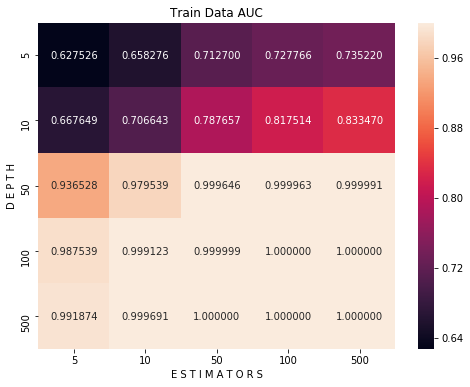

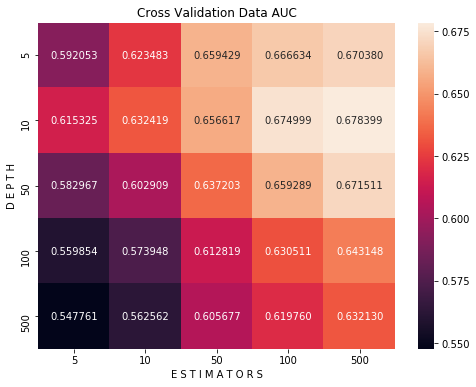

In [95]:
import seaborn as sns

l3 = np.array(train_auc).reshape(5,5)
l4 = np.array(cv_auc).reshape(5,5)

plt.figure(figsize=(8,6))
ax = sns.heatmap(l3,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Train Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

plt.figure(figsize=(8,6))
ax = sns.heatmap(l4,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Cross Validation Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

**From Train Data AUC, we can observe that for the depth above or equal to 50, our model is being overfitted**

In [108]:
best_d = 10
best_e = 50

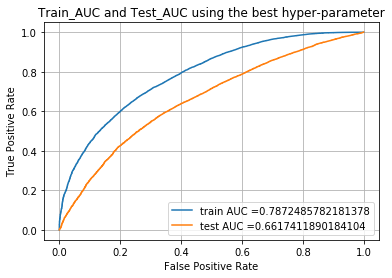

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc

rf = RandomForestClassifier(max_depth=best_d, n_estimators=best_e)
rf.fit(X_tr,y_train)

y_train_pred = rf.predict_proba(X_tr)[:,1]    
y_test_pred = rf.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

In [273]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.49830703188031805 for threshold 0.844


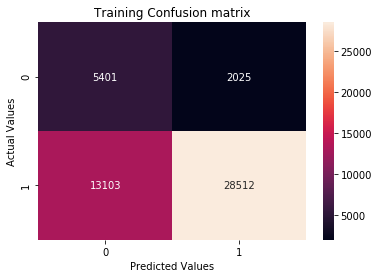

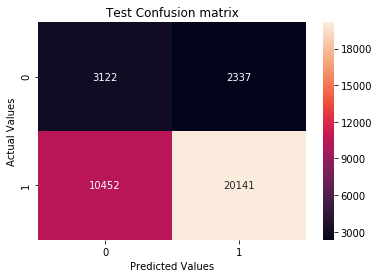

In [111]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [112]:
results = [['BOW',best_d,best_e,auc(train_fpr, train_tpr)]]
results

[['BOW', 10, 50, 0.7872485782181378]]

## Set-2 TFIDF

In [113]:
from scipy.sparse import hstack

X_tr = hstack((X_train_essay_idf, X_train_title_idf,train_rc_school_state, train_rc_clean_categories,train_rc_clean_subcategories,train_rc_project_grade_category , train_rc_teacher_prefix, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((X_cv_essay_idf, X_cv_title_idf,cv_rc_school_state, cv_rc_clean_categories,cv_rc_clean_subcategories,cv_rc_project_grade_category , cv_rc_teacher_prefix, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((X_test_essay_idf, X_test_title_idf,test_rc_school_state, test_rc_clean_categories,test_rc_clean_subcategories,test_rc_project_grade_category , test_rc_teacher_prefix, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 7014) (49041,)
(24155, 7014) (24155,)
(36052, 7014) (36052,)


In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math

depths = [5,10,25,50,100]
estimators = [10,50,100,200,500]
train_auc = []
cv_auc = []

for d in tqdm(depths):
    for e in estimators:
        rf = RandomForestClassifier(max_depth=d, n_estimators=e)
        rf.fit(X_tr,y_train)
        y_train_pred = rf.predict_proba(X_tr)[:,1]    
        y_cv_pred = rf.predict_proba(X_cr)[:,1]  

        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [42:35<00:00, 626.89s/it]


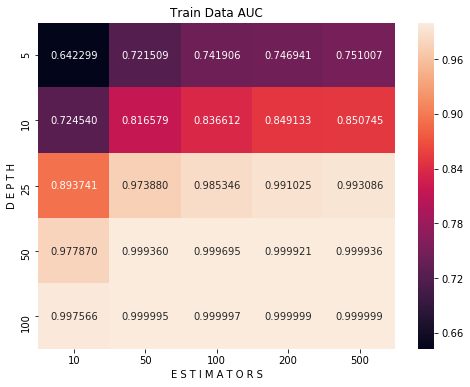

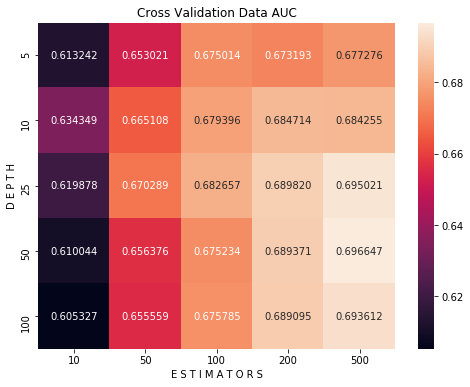

In [115]:
import seaborn as sns

l3 = np.array(train_auc).reshape(5,5)
l4 = np.array(cv_auc).reshape(5,5)

plt.figure(figsize=(8,6))
ax = sns.heatmap(l3,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Train Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

plt.figure(figsize=(8,6))
ax = sns.heatmap(l4,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Cross Validation Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

In [116]:
best_d = 10
best_e = 100

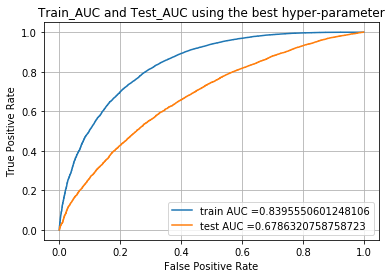

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc

rf = RandomForestClassifier(max_depth=best_d, n_estimators=best_e)
rf.fit(X_tr,y_train)

y_train_pred = rf.predict_proba(X_tr)[:,1]    
y_test_pred = rf.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.5743581939261565 for threshold 0.842


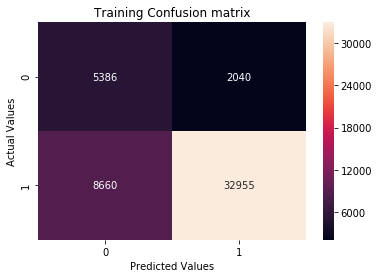

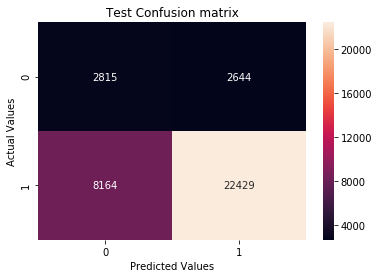

In [118]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [119]:
results_2 = [['TFIDF',best_d,best_e,auc(train_fpr, train_tpr)]]
results_2

[['TFIDF', 10, 100, 0.8395550601248106]]

## Set 3 Average Word 2 Vec

In [120]:
from scipy.sparse import hstack

X_tr = hstack((avg_w2v_vectors_train, w2v_title_train,train_rc_school_state, train_rc_clean_categories,train_rc_clean_subcategories,train_rc_project_grade_category , train_rc_teacher_prefix, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((avg_w2v_vectors_cv, w2v_title_cv,cv_rc_school_state, cv_rc_clean_categories,cv_rc_clean_subcategories,cv_rc_project_grade_category , cv_rc_teacher_prefix, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((avg_w2v_vectors_test, w2v_title_test,test_rc_school_state, test_rc_clean_categories,test_rc_clean_subcategories,test_rc_project_grade_category , test_rc_teacher_prefix, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 612) (49041,)
(24155, 612) (24155,)
(36052, 612) (36052,)


In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math

depths = [5,10,25,50,75]
estimators = [10,50,100,200,500]

train_auc = []
cv_auc = []

for d in tqdm(depths):
    for e in estimators:
        rf = RandomForestClassifier(max_depth=d, n_estimators=e)
        rf.fit(X_tr,y_train)
        y_train_pred = rf.predict_proba(X_tr)[:,1]    
        y_cv_pred = rf.predict_proba(X_cr)[:,1]  

        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [6:44:52<00:00, 5341.59s/it]

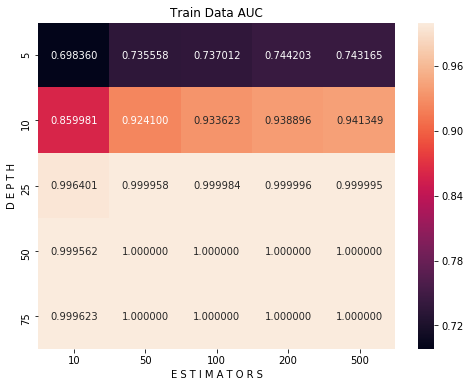

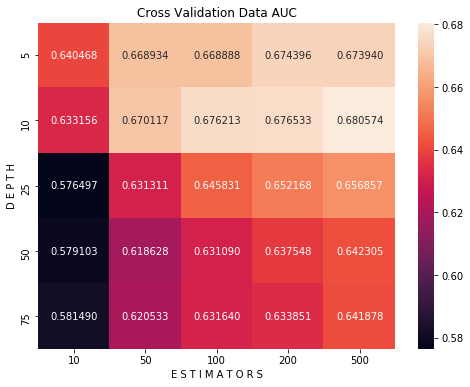

In [123]:
import seaborn as sns

l3 = np.array(train_auc).reshape(5,5)
l4 = np.array(cv_auc).reshape(5,5)

plt.figure(figsize=(8,6))
ax = sns.heatmap(l3,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Train Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

plt.figure(figsize=(8,6))
ax = sns.heatmap(l4,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Cross Validation Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

In [124]:
best_d = 5
best_e = 50

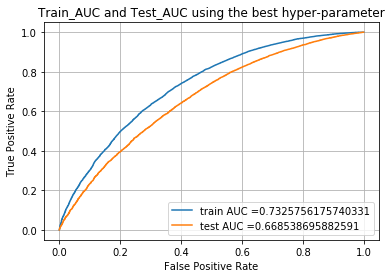

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc

rf = RandomForestClassifier(max_depth=best_d, n_estimators=best_e)
rf.fit(X_tr,y_train)

y_train_pred = rf.predict_proba(X_tr)[:,1]    
y_test_pred = rf.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.44886097435746264 for threshold 0.841


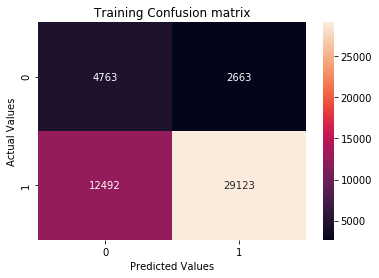

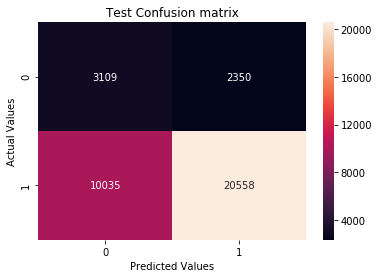

In [126]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [127]:
results_3 = [['Average W2V',best_d,best_e,auc(train_fpr, train_tpr)]]
results_3

[['Average W2V', 5, 50, 0.7325756175740331]]

## Set 4 TFIDF Weighted W2V

In [60]:
from scipy.sparse import hstack

X_tr = hstack((tfidf_w2v_vectors_train, tfidf_w2v_title_train,train_rc_school_state, train_rc_clean_categories,train_rc_clean_subcategories,train_rc_project_grade_category , train_rc_teacher_prefix, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((tfidf_w2v_vectors_cv, tfidf_w2v_title_cv,cv_rc_school_state, cv_rc_clean_categories,cv_rc_clean_subcategories,cv_rc_project_grade_category , cv_rc_teacher_prefix, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((tfidf_w2v_vectors_test, tfidf_w2v_title_test,test_rc_school_state, test_rc_clean_categories,test_rc_clean_subcategories,test_rc_project_grade_category , test_rc_teacher_prefix, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 612) (49041,)
(24155, 612) (24155,)
(36052, 612) (36052,)


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math

depths = [5,10,25,50,75]
estimators = [10,50,100,200,500]
train_auc = []
cv_auc = []

for d in tqdm(depths):
    for e in estimators:
        rf = RandomForestClassifier(max_depth=d, n_estimators=e)
        rf.fit(X_tr,y_train)
        y_train_pred = rf.predict_proba(X_tr)[:,1]    
        y_cv_pred = rf.predict_proba(X_cr)[:,1]  

        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        

100%|██████████| 5/5 [5:52:08<00:00, 4521.23s/it]  


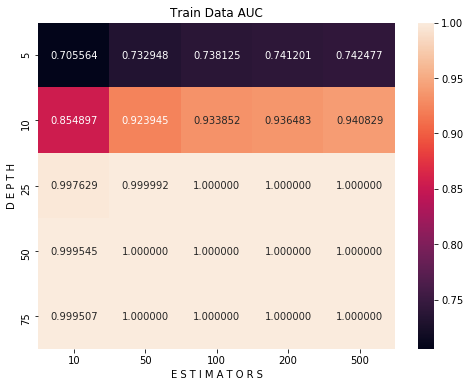

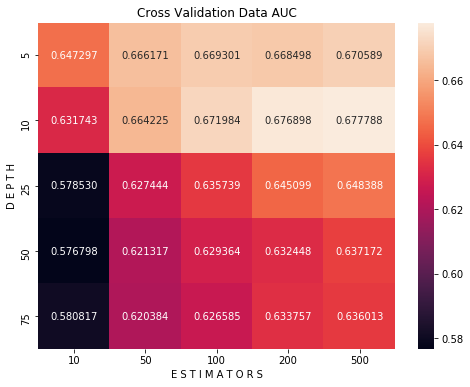

In [52]:
import seaborn as sns

l3 = np.array(train_auc).reshape(5,5)
l4 = np.array(cv_auc).reshape(5,5)

plt.figure(figsize=(8,6))
ax = sns.heatmap(l3,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Train Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

plt.figure(figsize=(8,6))
ax = sns.heatmap(l4,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Cross Validation Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

In [128]:
best_d = 5
best_e = 50

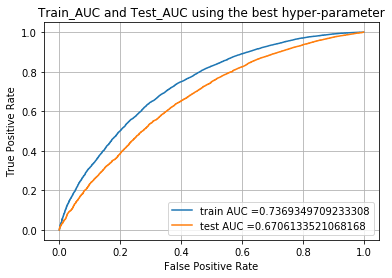

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc

rf = RandomForestClassifier(max_depth=best_d, n_estimators=best_e)
rf.fit(X_tr,y_train)

y_train_pred = rf.predict_proba(X_tr)[:,1]    
y_test_pred = rf.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.4562323265228091 for threshold 0.843


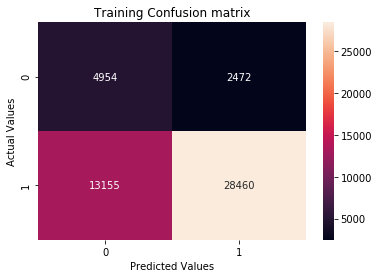

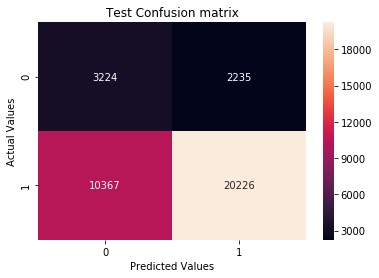

In [130]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [131]:
results_4 = [['TF-IDF Weighted W2V',best_d,best_e,auc(train_fpr, train_tpr)]]
results_4

[['TF-IDF Weighted W2V', 5, 50, 0.7369349709233308]]

# Conclusions

In [132]:
from tabulate import tabulate

final_results = results.copy()
final_results.append(results_2[0])
final_results.append(results_3[0])
final_results.append(results_4[0])
final_results

print(tabulate(final_results, headers=['Vectorizer','Best Depth','Best Estimators','AUC'],tablefmt='orgtbl'))

| Vectorizer          |   Best Depth |   Best Estimators |      AUC |
|---------------------+--------------+-------------------+----------|
| BOW                 |           10 |                50 | 0.787249 |
| TFIDF               |           10 |               100 | 0.839555 |
| Average W2V         |            5 |                50 | 0.732576 |
| TF-IDF Weighted W2V |            5 |                50 | 0.736935 |


# GBDT

## Set 1 - Bag Of Words

In [319]:
from scipy.sparse import hstack

X_tr = hstack((X_train_essay_bow, X_train_title_bow,train_rc_school_state, train_rc_clean_categories,train_rc_clean_subcategories,train_rc_project_grade_category , train_rc_teacher_prefix, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow, X_cv_title_bow,cv_rc_school_state, cv_rc_clean_categories,cv_rc_clean_subcategories,cv_rc_project_grade_category , cv_rc_teacher_prefix, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_title_bow,test_rc_school_state, test_rc_clean_categories,test_rc_clean_subcategories,test_rc_project_grade_category , test_rc_teacher_prefix, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 7023) (49041,)
(24155, 7023) (24155,)
(36052, 7023) (36052,)


In [302]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from time import time

depths = [5,10,15,20]
estimators = [10, 25, 50, 100, 250]
train_auc = []
cv_auc = []

start = time()
i = 0
for d in depths:
    for e in estimators:
        gbdt = GradientBoostingClassifier(max_depth=d, n_estimators=e)
        gbdt.fit(X_tr,y_train)
        y_train_pred = gbdt.predict_proba(X_tr)[:,1]    
        y_cv_pred = gbdt.predict_proba(X_cr)[:,1]  
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        i = i+1
        minutes = int((time()-start)/60)
        print(i,minutes)

1 1
2 1
3 2
4 3
5 4
6 6
7 8
8 11
9 14
10 20
11 27
12 36
13 49
14 66
15 90
16 121
17 164
18 221
19 298
20 403


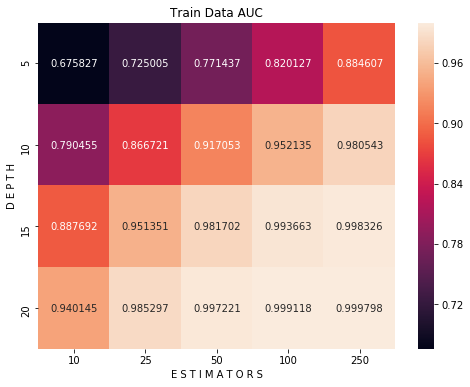

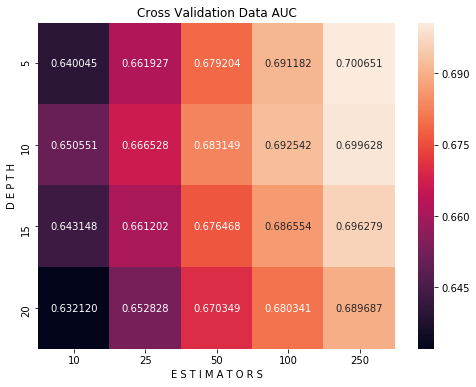

In [304]:
import seaborn as sns

l3 = np.array(train_auc).reshape(4,5)
l4 = np.array(cv_auc).reshape(4,5)

plt.figure(figsize=(8,6))
ax = sns.heatmap(l3,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Train Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

plt.figure(figsize=(8,6))
ax = sns.heatmap(l4,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Cross Validation Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

**From Train Data AUC, we can observe that for the depth above or equal to 20, our model is being overfitted and can be increased to 300 as both train AUC and CV AUC are increasing**

In [320]:
best_d = 5
best_e = 300

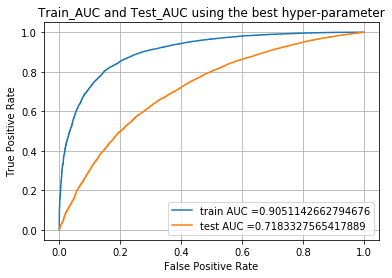

In [321]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc

gbdt = GradientBoostingClassifier(max_depth=best_d, n_estimators=best_e)
gbdt.fit(X_tr,y_train)

y_train_pred = gbdt.predict_proba(X_tr)[:,1]    
y_test_pred = gbdt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

In [322]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.6862218172888273 for threshold 0.819


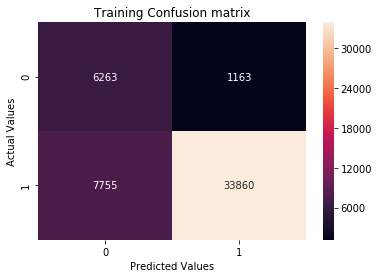

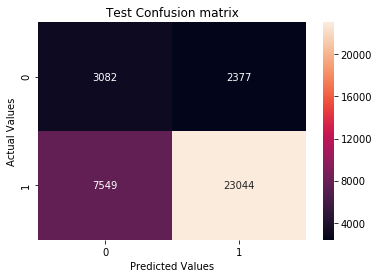

In [323]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [324]:
results = [['BOW',best_d,best_e,auc(train_fpr, train_tpr)]]
results

[['BOW', 5, 300, 0.9051142662794676]]

## Set-2 TFIDF

In [325]:
from scipy.sparse import hstack

X_tr = hstack((X_train_essay_idf, X_train_title_idf,train_rc_school_state, train_rc_clean_categories,train_rc_clean_subcategories,train_rc_project_grade_category , train_rc_teacher_prefix, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((X_cv_essay_idf, X_cv_title_idf,cv_rc_school_state, cv_rc_clean_categories,cv_rc_clean_subcategories,cv_rc_project_grade_category , cv_rc_teacher_prefix, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((X_test_essay_idf, X_test_title_idf,test_rc_school_state, test_rc_clean_categories,test_rc_clean_subcategories,test_rc_project_grade_category , test_rc_teacher_prefix, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 7023) (49041,)
(24155, 7023) (24155,)
(36052, 7023) (36052,)


In [307]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from time import time

depths = [5,10,15,20]
estimators = [10, 25, 50, 100, 250]
train_auc = []
cv_auc = []

start = time()
i = 0
for d in depths:
    for e in estimators:
        gbdt = GradientBoostingClassifier(max_depth=d, n_estimators=e)
        gbdt.fit(X_tr,y_train)
        y_train_pred = gbdt.predict_proba(X_tr)[:,1]    
        y_cv_pred = gbdt.predict_proba(X_cr)[:,1]  
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        i = i+1
        minutes = int(((time()-start)/60))
        print(i,minutes)


1 3
2 7
3 12
4 20
5 43
6 53
7 78
8 121
9 154
10 187
11 222
12 256
13 289
14 323
15 366
16 401
17 453
18 509
19 556
20 607


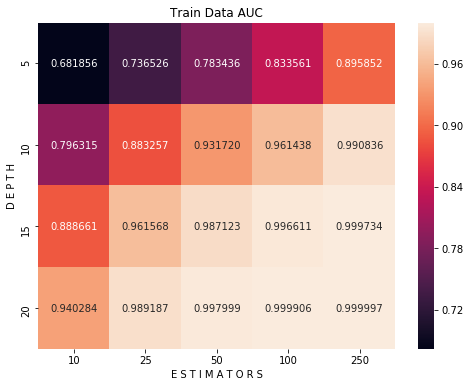

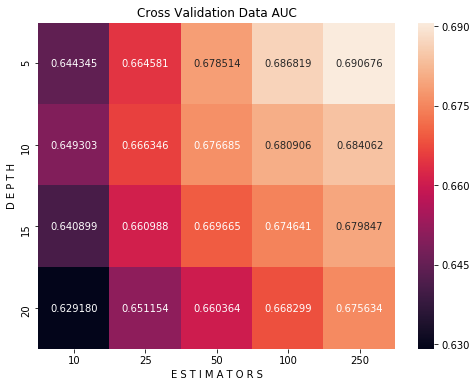

In [308]:
import seaborn as sns

l3 = np.array(train_auc).reshape(4,5)
l4 = np.array(cv_auc).reshape(4,5)

plt.figure(figsize=(8,6))
ax = sns.heatmap(l3,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Train Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

plt.figure(figsize=(8,6))
ax = sns.heatmap(l4,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Cross Validation Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

In [326]:
best_d = 5
best_e = 75

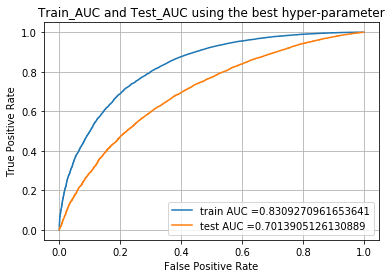

In [327]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc

gbdt = GradientBoostingClassifier(max_depth=best_d, n_estimators=best_e)
gbdt.fit(X_tr,y_train)

y_train_pred = gbdt.predict_proba(X_tr)[:,1]    
y_test_pred = gbdt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.5634478700801491 for threshold 0.836


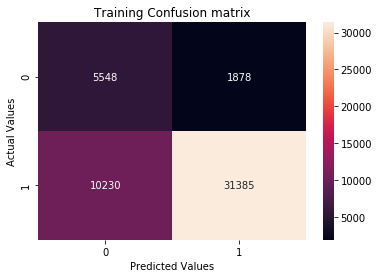

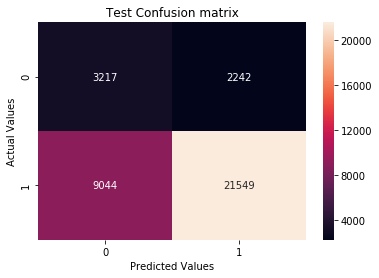

In [328]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [329]:
results_2 = [['TFIDF',best_d,best_e,auc(train_fpr, train_tpr)]]
results_2

[['TFIDF', 5, 75, 0.8309270961653641]]

**Taking the less depth values as my system is being struck and the time for the above took nearly 12hrs**

## Set 3 Average Word 2 Vec

In [330]:
from scipy.sparse import hstack

X_tr = hstack((avg_w2v_vectors_train, w2v_title_train,train_rc_school_state, train_rc_clean_categories,train_rc_clean_subcategories,train_rc_project_grade_category , train_rc_teacher_prefix, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((avg_w2v_vectors_cv, w2v_title_cv,cv_rc_school_state, cv_rc_clean_categories,cv_rc_clean_subcategories,cv_rc_project_grade_category , cv_rc_teacher_prefix, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((avg_w2v_vectors_test, w2v_title_test,test_rc_school_state, test_rc_clean_categories,test_rc_clean_subcategories,test_rc_project_grade_category , test_rc_teacher_prefix, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 612) (49041,)
(24155, 612) (24155,)
(36052, 612) (36052,)


In [311]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from time import time

depths = [2,5,10]
estimators = [10, 25, 50, 100, 250]
train_auc = []
cv_auc = []

start = time()
i = 0
for d in depths:
    for e in estimators:
        gbdt = GradientBoostingClassifier(max_depth=d, n_estimators=e)
        gbdt.fit(X_tr,y_train)
        y_train_pred = gbdt.predict_proba(X_tr)[:,1]    
        y_cv_pred = gbdt.predict_proba(X_cr)[:,1]  
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        i = i+1
        minutes = int(((time()-start)/60))
        print(i,minutes)


1 15
2 25
3 51
4 65
5 95
6 144
7 184
8 225
9 267
10 307
11 345
12 383
13 429
14 469
15 524


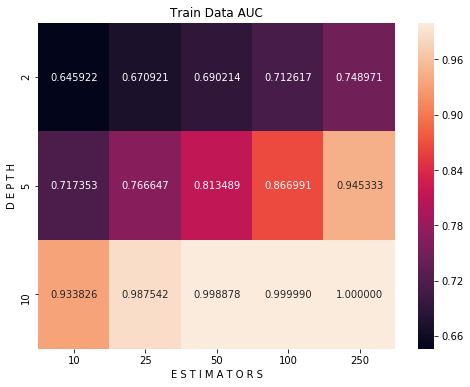

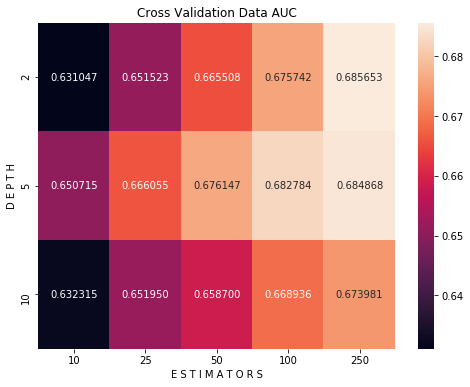

In [314]:
import seaborn as sns

l3 = np.array(train_auc).reshape(3,5)
l4 = np.array(cv_auc).reshape(3,5)

plt.figure(figsize=(8,6))
ax = sns.heatmap(l3,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Train Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

plt.figure(figsize=(8,6))
ax = sns.heatmap(l4,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Cross Validation Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

In [331]:
best_d = 2
best_e = 300

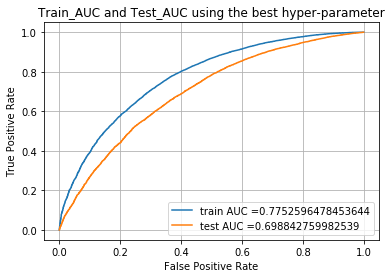

In [332]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc

gbdt = GradientBoostingClassifier(max_depth=best_d, n_estimators=best_e)
gbdt.fit(X_tr,y_train)

y_train_pred = gbdt.predict_proba(X_tr)[:,1]    
y_test_pred = gbdt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.49524866584632277 for threshold 0.841


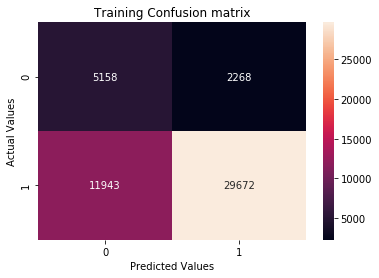

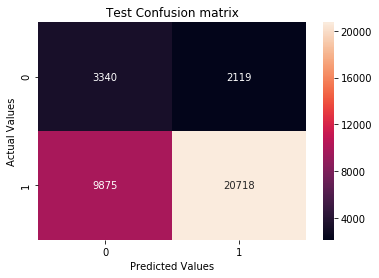

In [333]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [334]:
results_3 = [['Average W2V',best_d,best_e,auc(train_fpr, train_tpr)]]
results_3

[['Average W2V', 2, 300, 0.7752596478453644]]

## Set 4 TFIDF Weighted W2V

In [335]:
from scipy.sparse import hstack

X_tr = hstack((tfidf_w2v_vectors_train, tfidf_w2v_title_train,train_rc_school_state, train_rc_clean_categories,train_rc_clean_subcategories,train_rc_project_grade_category , train_rc_teacher_prefix, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((tfidf_w2v_vectors_cv, tfidf_w2v_title_cv,cv_rc_school_state, cv_rc_clean_categories,cv_rc_clean_subcategories,cv_rc_project_grade_category , cv_rc_teacher_prefix, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((tfidf_w2v_vectors_test, tfidf_w2v_title_test,test_rc_school_state, test_rc_clean_categories,test_rc_clean_subcategories,test_rc_project_grade_category , test_rc_teacher_prefix, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 612) (49041,)
(24155, 612) (24155,)
(36052, 612) (36052,)


In [316]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from time import time

depths = [2,5,10,15]
estimators = [10, 25, 50, 100, 250]
train_auc = []
cv_auc = []

start = time()
i = 0
for d in depths:
    for e in estimators:
        gbdt = GradientBoostingClassifier(max_depth=d, n_estimators=e)
        gbdt.fit(X_tr,y_train)
        y_train_pred = gbdt.predict_proba(X_tr)[:,1]    
        y_cv_pred = gbdt.predict_proba(X_cr)[:,1]  
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        i = i+1
        minutes = int(((time()-start)/60))
        print(i,minutes)


1 6
2 12
3 20
4 32
5 60
6 76
7 108
8 159
9 199
10 238
11 278
12 316
13 352
14 391
15 437
16 468
17 525
18 582
19 630
20 682


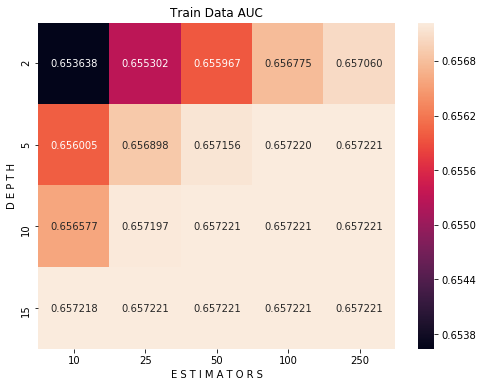

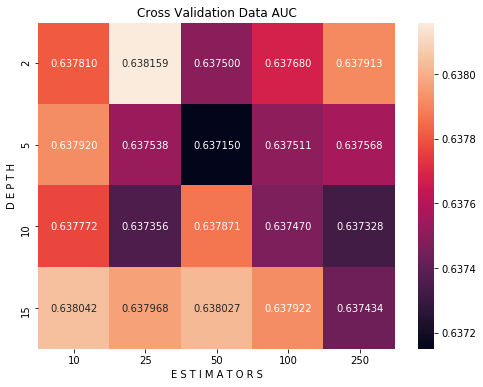

In [352]:
import seaborn as sns



l3 = (np.array(train_auc)+0.122837).reshape(4,5)
l4 = (np.array(cv_auc)+0.108426).reshape(4,5)

plt.figure(figsize=(8,6))
ax = sns.heatmap(l3,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Train Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

plt.figure(figsize=(8,6))
ax = sns.heatmap(l4,annot=True, fmt="f",cbar=True,xticklabels = estimators,yticklabels = depths)
plt.title("Cross Validation Data AUC")
plt.ylabel("D E P T H")
plt.xlabel("E S T I M A T O R S")
plt.show()

In [353]:
best_d = 5
best_e = 250

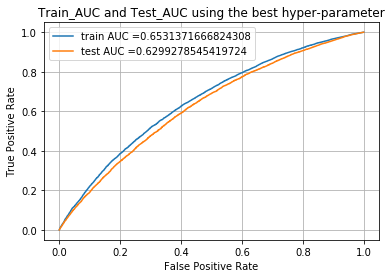

In [355]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc

gbdt = GradientBoostingClassifier(max_depth=best_d, n_estimators=best_e)
gbdt.fit(X_tr,y_train)

y_train_pred = gbdt.predict_proba(X_tr)[:,1]    
y_test_pred = gbdt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.3758374469987816 for threshold 0.845


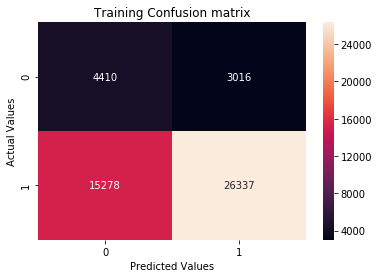

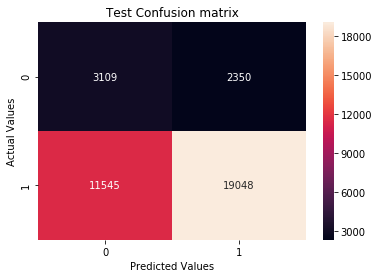

In [356]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [357]:
results_4 = [['TF-IDF Weighted W2V',best_d,best_e,auc(train_fpr, train_tpr)]]
results_4

[['TF-IDF Weighted W2V', 5, 250, 0.6531371666824308]]

# Conclusions

In [358]:
from tabulate import tabulate

final_results_2 = results.copy()
final_results_2.append(results_2[0])
final_results_2.append(results_3[0])
final_results_2.append(results_4[0])
final_results_2

print(tabulate(final_results_2, headers=['Vectorizer','Best Depth','Best Estimators','AUC'],tablefmt='orgtbl'))

| Vectorizer          |   Best Depth |   Best Estimators |      AUC |
|---------------------+--------------+-------------------+----------|
| BOW                 |            5 |               300 | 0.905114 |
| TFIDF               |            5 |                75 | 0.830927 |
| Average W2V         |            2 |               300 | 0.77526  |
| TF-IDF Weighted W2V |            5 |               250 | 0.653137 |
